In [79]:
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec

import astropy

from astropy.io import fits
from astropy import units as u
from astropy.table import Table, vstack

from astropy import modeling
from astropy.modeling import models, fitting

from astropy import constants as cnst
from astropy import constants as const
####################################

%matplotlib inline
from matplotlib import pyplot as plt
import pipeline
from photutils import centroid_com
import pandas as pd
import math as m
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from astropy.stats import sigma_clip
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter


from astropy.visualization import quantity_support
quantity_support() #not sure about this line but stackoverflow...try w/o it later

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x127445358>

In [80]:
#amending pipeline code to get sky subtraction separate from 1d spec

def sky_subtract2D(comb,skyaps,model):    
    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(10,25)) #setting up fig size
    value = model[1]
    if model == 'linear':
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0)) #(1,0)
    elif model == ('poly',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Polynomial1D(value)) #Linear1D(1/10,10)) #(1,0)
    elif model == ('combined',value):
        mymodel=(modeling.models.Polynomial1D(value) + modeling.models.Linear1D(1,0))
        subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
    elif model == None:
        subimg, models = comb.subtract_sky(skyaps, skymodel=None)#subtracts mean
    else:
        print ("Model type or polynomial degree not recognized")
    return (subimg, comb, models)    #subtracted2D, original, fitted models per row


def show_image(comb, **kwargs): #comb-self
        """
        Matplotlib imshow of this image

        transpose image for blue side unless transpose=False is given

        if log=True is given,the whole image will be linearly rescaled to 1-100
        before log-ifying, possibly be vmin/vmax
        """
        from matplotlib import pyplot as plt

        kwargs.setdefault('interpolation', 'nearest')
        kwargs.setdefault('transpose', self.side=='blue')

        if kwargs.pop('log', False):
            safedata = self.data[np.isfinite(self.data)]
            #use vmin and vmax to rescale  1-100
            lmin = kwargs.pop('logmin', None)
            lmax = kwargs.pop('logmax', None)
            mx = lmax if lmax else np.max(safedata)
            mi = lmin if lmin else np.min(safedata)
            rescaleddata = ((comb.data - mi) / (mx - mi)) #comb-self
            rescaleddata[rescaleddata>1] = 1
            rescaleddata[rescaleddata<0] = 0
            d = np.log10(rescaleddata*99.+1.)
        else:
            d = comb.data #comb-self
        if kwargs.pop('transpose'):
            d = d.T
        res = plt.imshow(d, **kwargs)
        return res

   #defining a function will use later to extract target's 1D spectrum from whole 2D data file 
def extract_spectrum(side, subtracted_2d, aperture):
        """
        Extract a 1D spectrum the "simple" (non-Horne) way
        
        Parameters
        ----------
        aperture : 2-tuple
            The edges of the aperture along the spatial axis
            
        Returns
        -------
        spectrum : array
            A 1D extracted spectrum with the *sum* of the flux.
        unc : 1D array
            The flux uncertainty matching the extracted spectrum
        """

        apslc = aperture if isinstance(aperture, slice) else slice(*aperture)
        if side == 'red':
            d = subtracted_2d.data
        elif side == 'blue':
            d = subtracted_2d.data.T
        else:
            raise ValueError('unrecognized side ')
        spec = np.sum(d[apslc], axis=0)
        unc = np.sum(d[apslc]**2, axis=0) ** 0.5
        unsum_spec = d[apslc]
        return spec, unc, unsum_spec #spec-1D spectrum for target
#spec is summed data for each pixel column(wl) within the spec aps range

In [81]:
#Finding all data file for specific target and doing instrumentation noise subtraction
flatid = 'DomeFlat'
atlasfiles_red = fits.open('henear.fits') #NOAO atlas  #RED side 
atlasfiles_blue = fits.open('fear.fits') #NOAO atlas #BLUE side 
linelist_red = reduce_dblspec.HENEAR_LINE_LIST #RED side
linelist_blue = reduce_dblspec.FEAR_LINE_LIST #BLUE side

############### possible changes to change targets
##################################################
arcfiles_red10 = 'DoubleSpec/20170518/red0012.fits' #ARC lamp #1.0" slit #RED side
arcfiles_blue10 = 'DoubleSpec/20170518/blue0012.fits' #ARC lamp #1.0" slit #BLUE side
targetID = '48721248845970-Dune'
all_side_files_red = 'DoubleSpec/20170518/red*.fits'#RED side
all_side_files_blue = 'DoubleSpec/20170518/blue*.fits'#BLUE side
#target = fits.open('DoubleSpec/20170518/red0079.fits') #use these to get targetid
#target[0].header
##################################################

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Red side


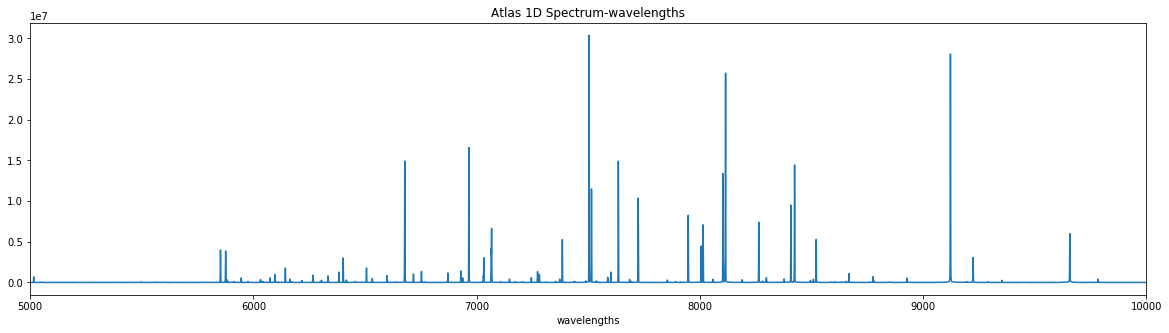

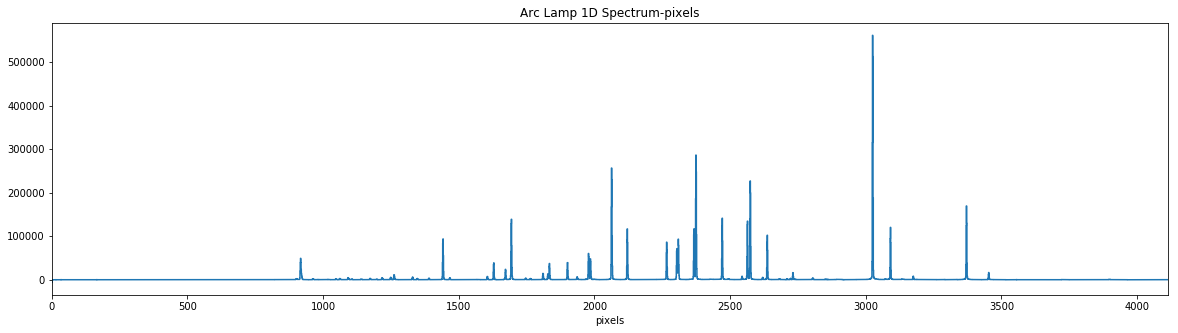

In [82]:
#creating a ds _ part one

#plotting arc lamp pixel data and atlas wl data to match lines in next cell
specset_red = pipeline.dispersion(all_side_files_red, atlasfiles_red, arcfiles_red10, linelist_red,flatid)

/Users/dee/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


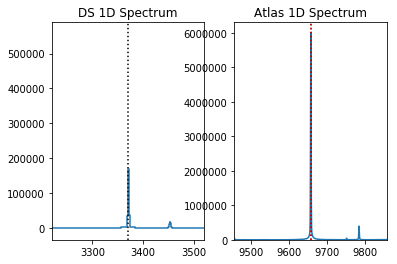

In [83]:
#creating a ds _ part two

#use above plots to enter guesses of matching lines
pipeline.guess_plot(3370,9657,specset_red) #(arc-PIX-guess, atlas-WL-from-linelist)

#collect guesses here ~5 seems good
pixel_guesses = [3024,2373,2062,1672,3370]
atlas_lines = [9122.9674,8115.311,7635.106,7032.4131,9657.7863]
guesses = list(zip(pixel_guesses, atlas_lines)) #must be tuples

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Failed to find line ArI at wl=7272.9359: "Guessed line's peak to base ratio is 7.605442276448056, which is less than 10"
Found line HeI at wl=7281.349
Clipped 0 lines
Failed to find line ArI at wl=7353.293: "Guessed line's peak to base ratio is 1.440416352893276, which is less than 10"
Failed to find line ArI at wl=7372.1184: "Guessed line's peak to base ratio is 1.886015039320914, which is less than 10"
Found line ArI at wl=7383.9805
Clipped 0 lines
Failed to find line NeI at wl=7488.8712: "Guessed line's peak to base ratio is 2.4296461377363423, which is less than 10"
Found line ArI at wl=7503.8691
Clipped 0 lines
Found line ArI at wl=7514.6518
Clipped 0 lines
Failed to find line NeI at wl=7535.7739: "Guessed line's peak to base ratio is 2.480156090889031, which is less than 10"
Failed to find line NeI at wl=7544.0443: "Guessed line's peak to base ratio is 1.2925552080633658, which is less than 10"
Failed to find line KrI at wl=7587.413: "Guessed line's peak to base ratio is 1.081955

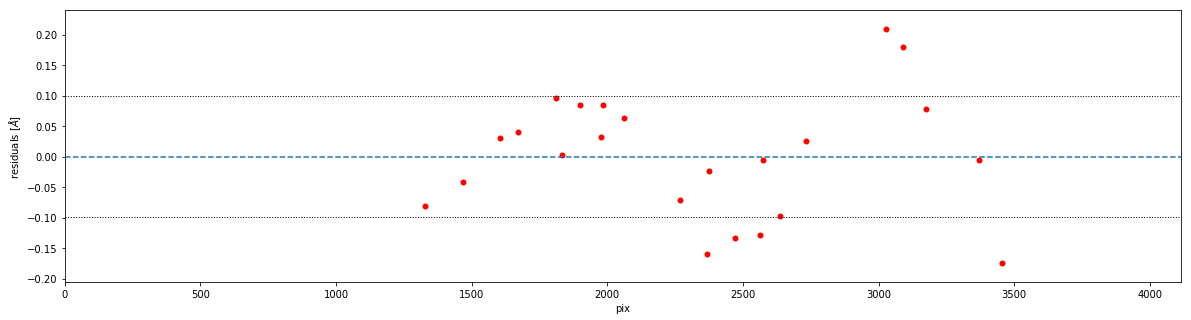

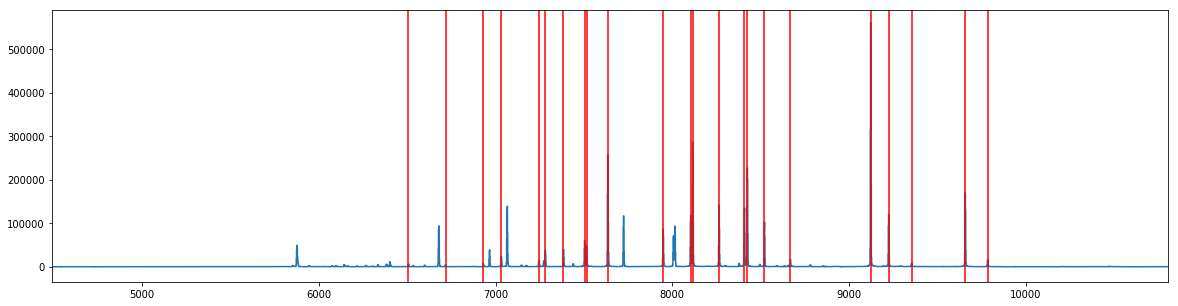

In [84]:
#creating a ds _ part three

ds_red = pipeline.goodness_of_matches(arcfiles_red10, guesses, all_side_files_red, atlasfiles_red, linelist_red, flatid);
#this is the final red side ds

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Blue side


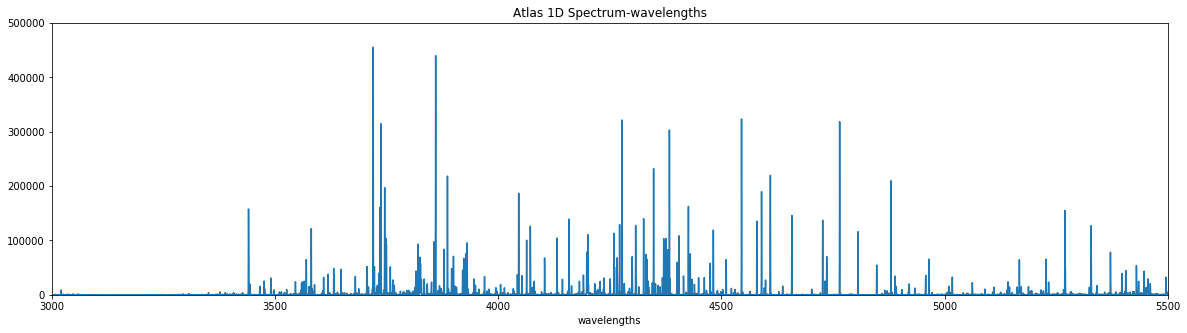

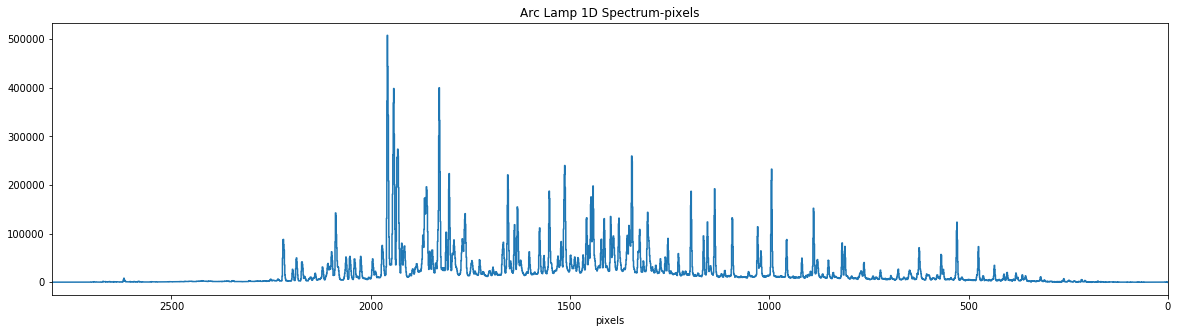

In [85]:
#creating a ds _ part one

#plotting arc lamp pixel data and atlas wl data to match lines in next cell
specset_blue = pipeline.dispersion(all_side_files_blue, atlasfiles_blue, arcfiles_blue10, linelist_blue,flatid)

/Users/dee/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


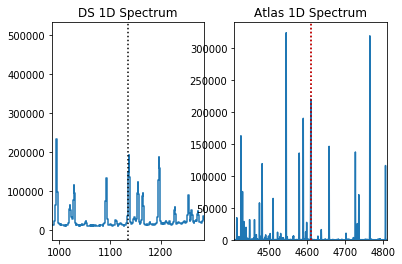

In [86]:
#creating a ds _ part two

#use above plots to enter guesses of matching lines
pipeline.guess_plot(1135,4609,specset_blue) #(arc-PIX-guess,atlas-WL-from-linelist)

#collect guesses here ~5 seems good
pixel_guesses = [1956,1827,993,1029,528]#badvals 1135
atlas_lines = [3719.9346, 3859.9114, 4764.8646, 4726.8683, 5269.5366] #badvals 4609.5673
guesses = list(zip(pixel_guesses, atlas_lines)) #must be tuples

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for blueside
chose guesses for blueside
Failed to find line FeI at wl=3020.6391: "Guessed line's peak to base ratio is 0.9283220677308877, which is less than 5"
Failed to find line FeI at wl=3024.0325: "Guessed line's peak to base ratio is 1.1792408779758057, which is less than 5"
Failed to find line FeI at wl=3037.3887: "Guessed line's peak to base ratio is 2.3370690055694463, which is less than 5"
Failed to find line FeI at wl=3047.6043: "Guessed line's peak to base ratio is 2.7543769339564936, which is less than 5"
Failed to find line FeI at wl=3057.4456: "Guessed line's peak to base ratio is 2.0635750414101492, which is less than 5"
Failed to find line FeI at wl=3059.0856: "Guessed line's peak to base ratio is 2.0635750414101492, which is less than 5"
Failed to find line FeI at wl=3225.785: "Guessed line's peak to base ratio is 0.9566180332361156, which is less than 5"
Failed to find line ArII at wl=3243.6887: "Guessed line's peak to base ratio is 1.1629140069854265, which

Found line FeI at wl=4383.5445
Clipped 0 lines
Found line ArII at wl=4385.0566
Clipped 0 lines
Failed to find line ArII at wl=4400.9863: "Guessed line's peak to base ratio is 1.3889079063371053, which is less than 5"
Failed to find line FeI at wl=4404.7499: "Guessed line's peak to base ratio is 2.8204945130694994, which is less than 5"
Found line FeI at wl=4415.1222
Clipped 0 lines
Failed to find line ArII at wl=4426.0011: "Guessed line's peak to base ratio is 2.9428349329845247, which is less than 5"
Failed to find line FeI at wl=4427.3039: "Guessed line's peak to base ratio is 2.9428349329845247, which is less than 5"
Failed to find line ArII at wl=4430.189: "Guessed line's peak to base ratio is 1.0812613136079958, which is less than 5"
Failed to find line ArII at wl=4433.838: "Guessed line's peak to base ratio is 0.9577671122405731, which is less than 5"
Failed to find line ArII at wl=4439.4614: "Guessed line's peak to base ratio is 1.7236504675250564, which is less than 5"
Failed t

Skipping line ArI at wl=8103.6931 - out of wl min/max
Skipping line ArI at wl=8115.311 - out of wl min/max
Skipping line ArI at wl=8143.505 - out of wl min/max
Skipping line ArI at wl=8203.4352 - out of wl min/max
Skipping line ArI at wl=8264.5225 - out of wl min/max
Skipping line FeI at wl=8327.0526 - out of wl min/max
Skipping line ArI at wl=8384.724 - out of wl min/max
Skipping line FeI at wl=8387.77 - out of wl min/max
Skipping line ArI at wl=8408.2096 - out of wl min/max
Skipping line ArI at wl=8424.6475 - out of wl min/max
Skipping line ArI at wl=8490.3065 - out of wl min/max
Skipping line ArI at wl=8521.4422 - out of wl min/max
Skipping line ArI at wl=8605.7762 - out of wl min/max
Skipping line ArI at wl=8620.4602 - out of wl min/max
Skipping line ArI at wl=8667.9442 - out of wl min/max
Skipping line FeI at wl=8688.6213 - out of wl min/max
Skipping line ArI at wl=8761.6862 - out of wl min/max
Skipping line ArI at wl=8799.0875 - out of wl min/max
Skipping line ArI at wl=8962.1468

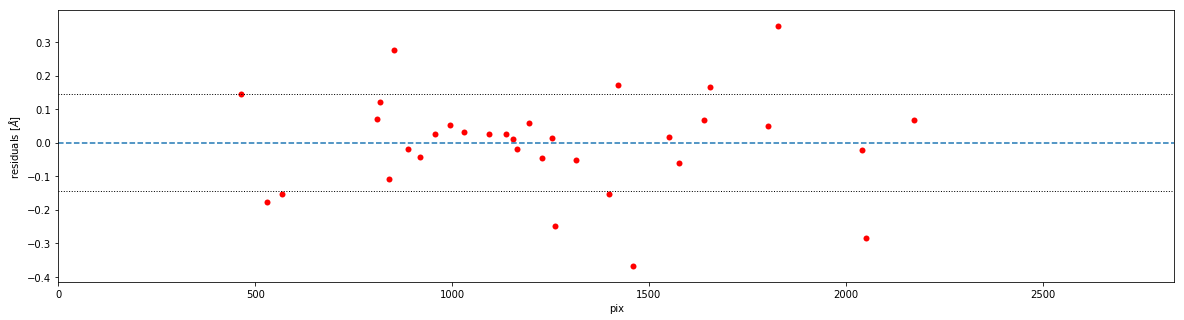

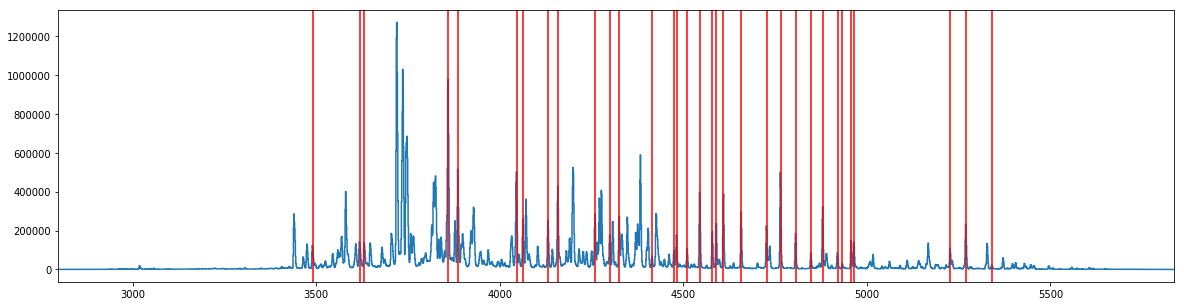

In [87]:
#creating a ds _ part three

ds_blue = pipeline.goodness_of_matches(arcfiles_blue10, guesses, all_side_files_blue, atlasfiles_blue, linelist_blue, flatid);
#this is the final blue side ds 

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


3 target files located
choose 2D spec for redside
choose 1D target spec axis limits for redside


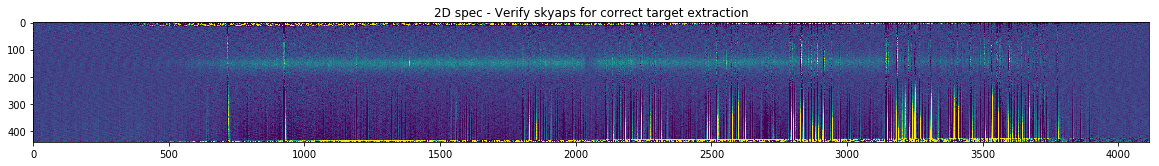

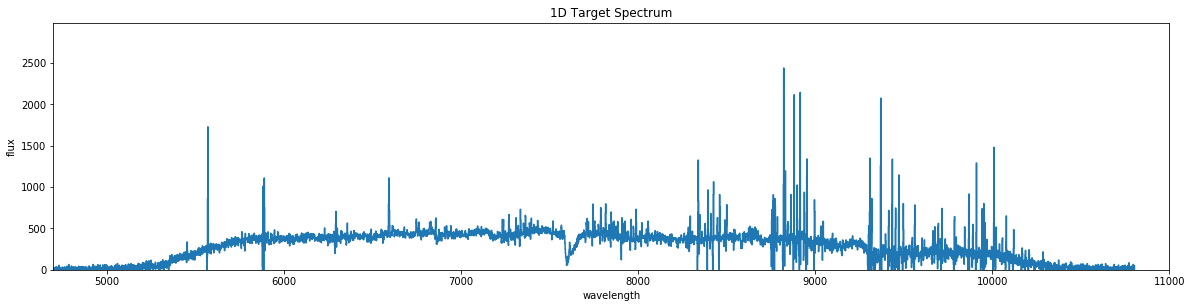

In [88]:
#RED side SPECTRUM

#define relevant pixel spatial regions
#####################################################
skyaps_red=[(20,95),(185,230)]#spatial regions above & below target to estimate sky emissions
model_red='linear' #estimating sky line tilt
specaps_red = (100,170)#WHAT IS THIS AGAIN? target spatial region? area btwn skyaps??
#####################################################

#helps color scale of 2D
vmax = 40
vmin = -10

#subtracts sky lines & stacks target images to extract 1D
target_flux_red, target_unc_red, target_comb_red = pipeline.sky_subtract(targetID, skyaps_red, ds_red, all_side_files_red, atlasfiles_red ,all_side_files_red, flatid, specaps_red, vmax, vmin, model_red)

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


3 target files located
choose 2D spec for blueside
choose 1D target spec axis limits for blueside


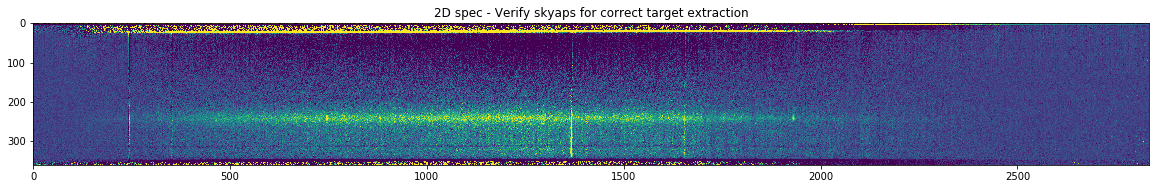

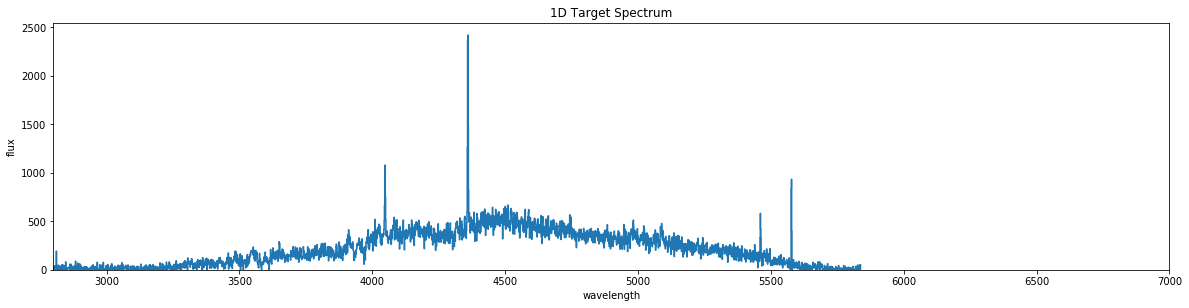

In [89]:
#BLUE side SPECTRUM

#define relevant pixel spatial regions
#####################################################
skyaps_blue = [(130,190),(318,350)]#spatial regions above & below target to estimate sky emissions
model_blue = 'linear'#('poly',2) #estimating sky line tilt
specaps_blue = (270,310)#target spatial region
#####################################################
#helps color scale of 2D
vmax = 40
vmin = -10

#subtracts sky lines & stacks target images to extract 1D
target_flux_blue, target_unc_blue, target_comb_blue = pipeline.sky_subtract(targetID, skyaps_blue, ds_blue, all_side_files_blue, atlasfiles_blue ,all_side_files_blue, flatid, specaps_blue, vmax, vmin, model_blue)

In [90]:
#isolates the sky-subtracted 2D spectrum

#choose best emission line side
##############################################
best_emission_comb = target_comb_red
best_emission_skyaps = skyaps_red
best_emission_model = model_red
##############################################

#sky-subtracting 2D
subimg2, comb2, fitmodels = sky_subtract2D(best_emission_comb, best_emission_skyaps, best_emission_model)
#subimg2 is sky-subtracted, instumentation noise subtracted, stacked data
#comb2 is original instrumentation noise subtracted, stacked data
#fitmodels is sky lines fitted to 'model' type

<Figure size 720x1800 with 0 Axes>

FLUX_DATA is the target's entire 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls)
flux data shape: (91, 4104)
NOTE 10 spectral PIXELS missing  WL_PIX_CORRECTION DEFINED HERE!!!!!! 


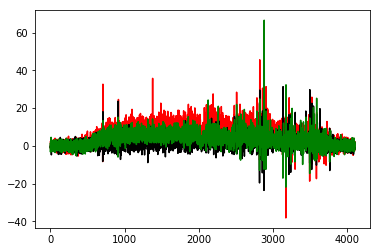

In [91]:
#PART ONE -----------------prep for centroiding

#first need to get target only 2D aka(1D spectrum for each spatial pixel row in the 2D target data)
############################################
target_aperature=(100,190) #target location
############################################
space_pix_correction = target_aperature[0]

flux_data=[] #to hold target only 2d spec
apslc = np.arange(target_aperature[0],target_aperature[1]+1,1) #list of rows to extract spec from
#np.shape(subimg2.data)#(440, 4114)


#extracting target spec from whole 2d spec
for i in apslc:
    spec = subimg2.data[i]#subimg2 is sky-subtracted 2D spec #this is every row's spec...
    
    #need to change if suming multiple pixel rows
    spec = spec[10::] #chops first 10 flux values in spectral (wl) direction-crazy osscillations
    flux_data.append(spec) #collects every row's spec within the target location
flux_data=np.array(flux_data)   
#need to find a way to sum over diff ranges of apslc 

#######################################################
#defining spectral correction factor (try to fit this into loop above later on)
wl_pix_correction = 10 #wont affect spatial pix values, only amount of flux but thats negligible
#######################################################

#just to visually confirm
plt.plot(flux_data[45],color='r')#near galaxy center
plt.plot(flux_data[15],color='k') #near galaxy edge
plt.plot(flux_data[67],color='g')#near opposite galaxy edge

#conclusions
print("FLUX_DATA is the target's entire 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls)" )
print('flux data shape:', np.shape(flux_data)) #(226, 4104)
print('NOTE 10 spectral PIXELS missing ', 
      'WL_PIX_CORRECTION DEFINED HERE!!!!!! ')

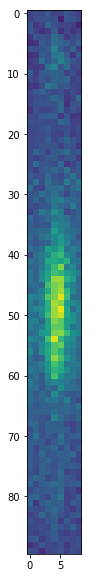

In [92]:
#PART TWO ----------------------determining best emission line pixel range

#using FULL ccd pixel range
################################################################
testingthis=subimg2.data[100:190,1383:1392] #[:,1386:1397]#[space,wl]for RED [wl,space]for BLUE
#conclusions
bestline_range_fullccd = (1383, 1392)
bestline_range_correction = (1373,1382) 
#################################################################

vmin=-10
vmax=45
plt.figure(figsize=(10,10))
plt.imshow(testingthis,vmin=vmin,vmax=vmax)#add in ,aspect='auto', to get square pixels

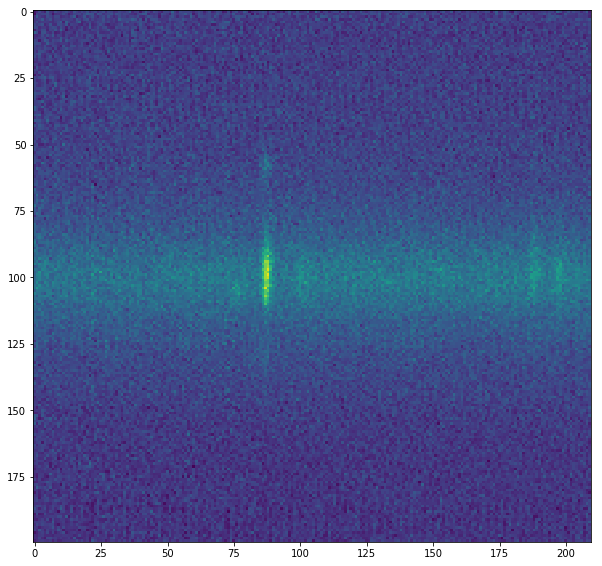

In [93]:
testingthistoo=subimg2.data[50:250,1300:1510]
vmin=-10
vmax=45
plt.figure(figsize=(10,10))
plt.imshow(testingthistoo,vmin=vmin,vmax=vmax)#add in ,aspect='auto', to get square pixels

length of means_unc is: 91


Text(0.5,1,'h-alpha centroids in pixel values')

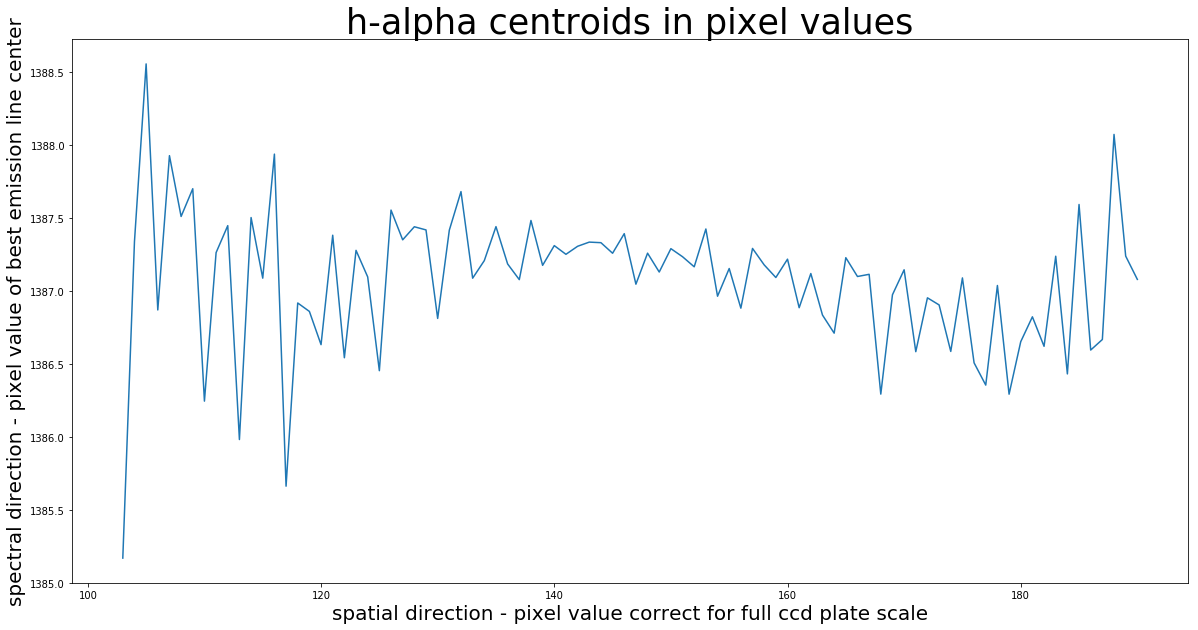

In [94]:
#PART THREE ------------------------------does the centroiding

#applies DS using full ccd pixel range 
#####################################################################
wl = np.array(ds_red.pixtowl(np.arange(len(subimg2.data[::][0]))))
#getting corresponding flux & wl values in best emission line region of 2D
wl_shorter2 = wl[1383:1392] #isolate wl around h-alpha using 'bestline_range_fullccd'
flux_data_short = flux_data[:,1373:1382] #use 'bestline_range_correction' range
#####################################################################


centroids_pix = []
mylist_ys2 = []
gfit_vals = []
stddev = []
means=[]
means_unc=[]




#gets halpha centroids/gaussians/uncertainities in target gal's range

for row in flux_data_short: 
    
    #calculates centroids per row
    flux_fake2d2 = row[np.newaxis, :] #makes each row array into a fake2d
    centroid_ys, centroid_xs = centroid_com(flux_fake2d2)#finds center(x,y) of best emission line for each row array
    mylist_ys2.append(centroid_ys)
    #print(centroid_xs, centroid_ys) #they switched order agaihn wtf
    centroids_pix.append(centroid_xs) #collects all best emission line centroids per row
    
    #calculating errors per row via gaussian fit
    x = ar(range(len(row)))
    y = row
    mean = centroid_xs
    g_init = models.Gaussian1D(amplitude=max(y), mean=mean, stddev=2.)
    fit_g = fitting.LevMarLSQFitter()
    gaussian = fit_g(g_init, x, y)
    gfit_vals.append(gaussian)
    stddev.append(gaussian.stddev.value)
    means.append(gaussian.mean.value)

    #trying to get uncertainities per row via covariance matrix
    gaussian.param_cov = fit_g.fit_info['param_cov']
    #means_unc.append(fit_g.fit_info['param_cov'][1][1])
    means_unc.append(fit_g.fit_info['param_cov'])#matrix fix
    #print('mytest',means_unc)


    
#end of for loop  - making things into arrays so easier to work with  
centroids_pix = np.array(centroids_pix) #best emission line centroids (wl) array
gfit_vals = np.array(gfit_vals)  #all gaussian outputs in pixels
gauss_stddev = np.array(stddev) #std of gaussians in pixels
gaussian_means = np.array(means) #gaussian peaks in pixels
print('length of means_unc is:',len(means_unc))

#converting pixel values to be wrt full cdd
#wl axis
centroid_specpix_fullccd = centroids_pix + wl_pix_correction + bestline_range_correction[0]
gaussmax_specpix_fullccd = gaussian_means + stddev + wl_pix_correction + bestline_range_correction[0]
gaussmeans_specpix_fullccd = gaussian_means + wl_pix_correction + bestline_range_correction[0]
#space axis
target_spacepix_fullccd = np.arange(len(centroids_pix)) + space_pix_correction


 
    
#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd[3::],centroid_specpix_fullccd[3::])#(spaital pix index,corrected "wl" of centroid values (still in pix space))
#plt.ylim(1382,1384)
###########################################################
plt.title('h-alpha centroids in pixel values',fontsize=35)
###########################################################

Text(0.5,1,'h-alpha gaussians in pixel values')

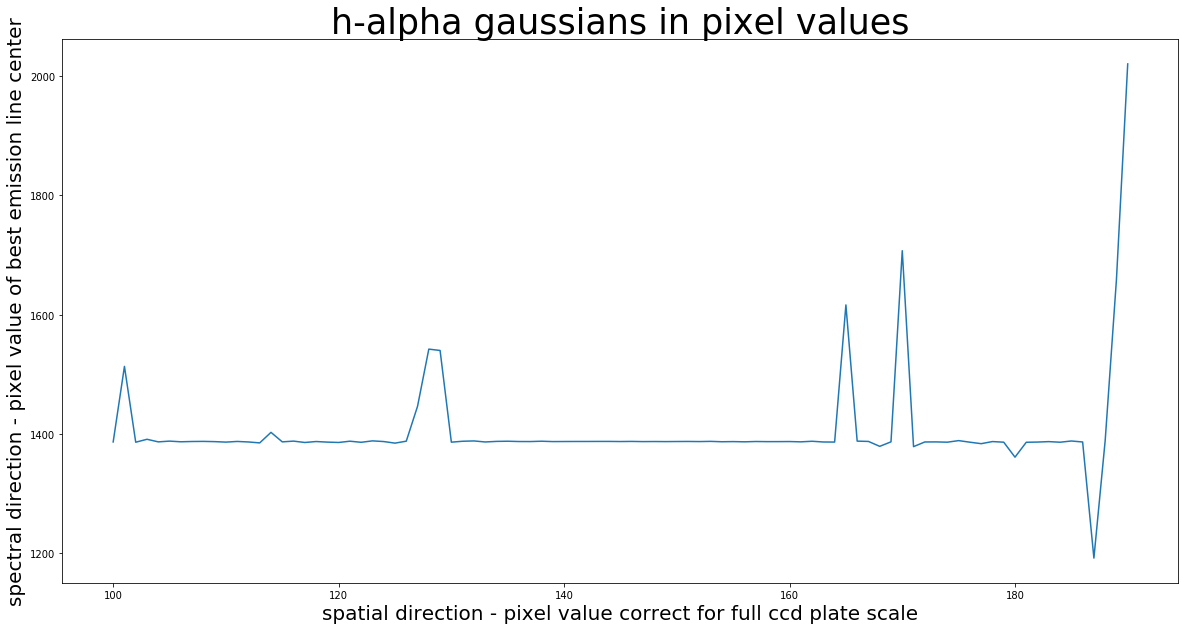

In [95]:
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,gaussmeans_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
plt.title('h-alpha gaussians in pixel values',fontsize=35)


(1384, 1389)

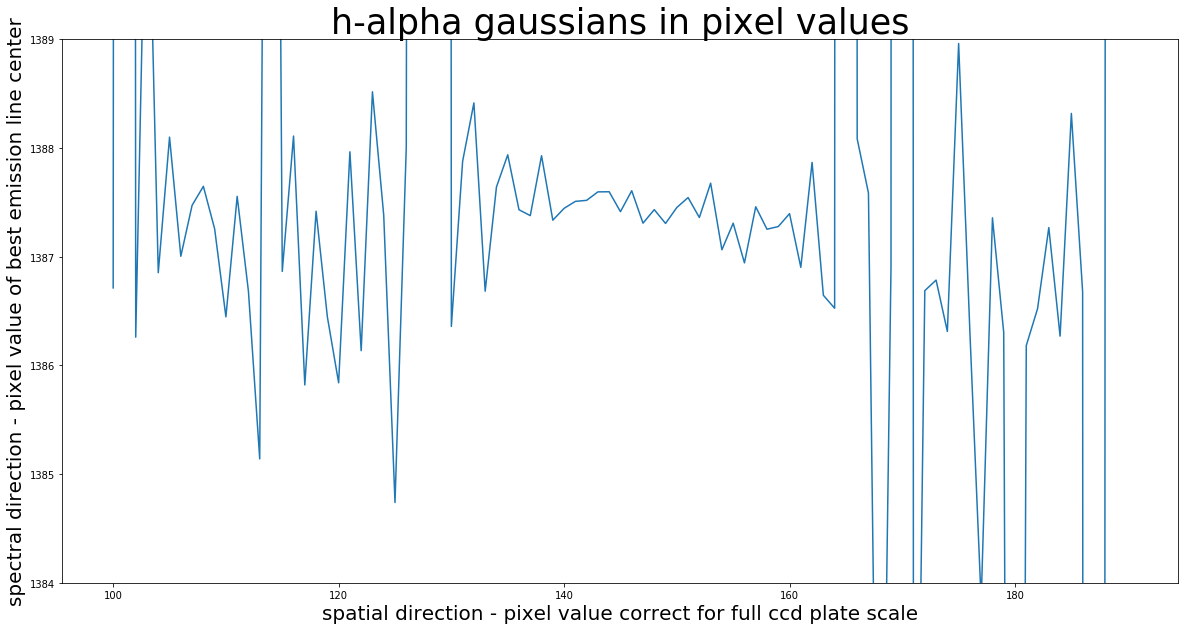

In [96]:
# ylims for comparison after matrix fix

plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,gaussmeans_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
plt.title('h-alpha gaussians in pixel values',fontsize=35)
plt.ylim(1384,1389)

## removes bad fits

In [97]:
#collecting indicies of bad matrices


matrix = np.arange(0,len(means_unc),1)
print('these should be the same, if not explore:',len(matrix),len(gaussian_means))

badindices = []
for i in matrix:
    #print()
    if np.any(means_unc[i]) == None:
        print('bad matrix at array:',i, means_unc[i])
        badindices.append(i)
    else:
        ok = 'ok'
        #print(ok)
        #print(means_unc[i])
print('number of bad fits is:',len(badindices))

these should be the same, if not explore: 91 91
bad matrix at array: 3 None
bad matrix at array: 28 None
bad matrix at array: 29 None
bad matrix at array: 65 None
bad matrix at array: 70 None
bad matrix at array: 87 None
bad matrix at array: 89 None
bad matrix at array: 90 None
number of bad fits is: 8


In [98]:
#masking bad uncertaiinty values


evenmore_badindices=[]
masked_gsigs_means=[]
for i in  range(len(means_unc)):
    #print(type(means_unc[i]))
    #if type(means_unc[i][1][1]) != np.ndarray:
    if type(means_unc[i]) == np.ndarray: #'NoneType':
        gmatrix_unc=means_unc[i][1][1]
        #print(i)
    #b/c these are the good fits, keep those vals
    else:
        gmatrix_unc=np.nan
        evenmore_bad = i
        evenmore_badindices.append(evenmore_bad)
        #print(i)
    #print(i, gmatrix_unc)
    masked_gsigs_means.append(gmatrix_unc)
evenmore_badindices = np.array(evenmore_badindices)
masked_gsigs_means = np.array(masked_gsigs_means)
#print(masked_gsigs_means)
print(evenmore_badindices,len(evenmore_badindices),badindices,'good they match, as they should')

[ 3 28 29 65 70 87 89 90] 8 [3, 28, 29, 65, 70, 87, 89, 90] good they match, as they should


In [99]:
#masking bad gaussian values


more2_badindices=[]
more_badindices=[]
masked_gaussian_means=[]
for i in  range(len(gaussian_means)):
    #b/c bad fit produced no cov matrix
    if i in badindices:
        gaussian_means[i] = np.nan
    #b/c mean value shouldnt be outside this pixel range
    elif gaussian_means[i] <=0.0:
        gaussian_means[i]=np.nan
        more2_bads = i
        more2_badindices.append(more2_bads)
###############depends on width of h-alpha######################################
    elif gaussian_means[i] >=9.0:
###############################################################################
        gaussian_means[i] = np.nan
        more2_bads=i
        more2_badindices.append(more2_bads)
    #b/c these are the good fits, keep those vals
    else:
        gaussian_means[i]=gaussian_means[i]
    #print(i,gaussian_means[i])
    masked_gaussian_means.append(gaussian_means[i])
#more_badindices = np.array(more_badindices)
more2_badindices = np.array(more2_badindices)
masked_gaussian_means = np.array(masked_gaussian_means)

In [100]:
#collecting all bad fit indicies.....NOT in fullccd pix space, in target pix space


all_bad_idx = np.concatenate([more2_badindices,evenmore_badindices])
all_bad_idxs = np.sort(all_bad_idx)
all_bad_idxs
#more2_badindices, evenmore_badindices

array([ 1,  3, 14, 27, 28, 29, 65, 68, 70, 71, 80, 87, 89, 90])

In [101]:
# changing those (evenmore bad indicies) values to nan in the uncertainity array


fullmask_sigma=[]
for i in  range(len(masked_gsigs_means)):
    #b/c bad fit produced no cov matrix
    if i in more2_badindices:
        masked_gsigs_means[i] = np.nan
    #b/c these are the good fits, keep those vals
    else:
        masked_gsigs_means[i]=masked_gsigs_means[i]
    #print(i,masked_gsigs_means[i])
    fullmask_sigma.append(masked_gsigs_means[i])
fullmask_sigma = np.array(fullmask_sigma)

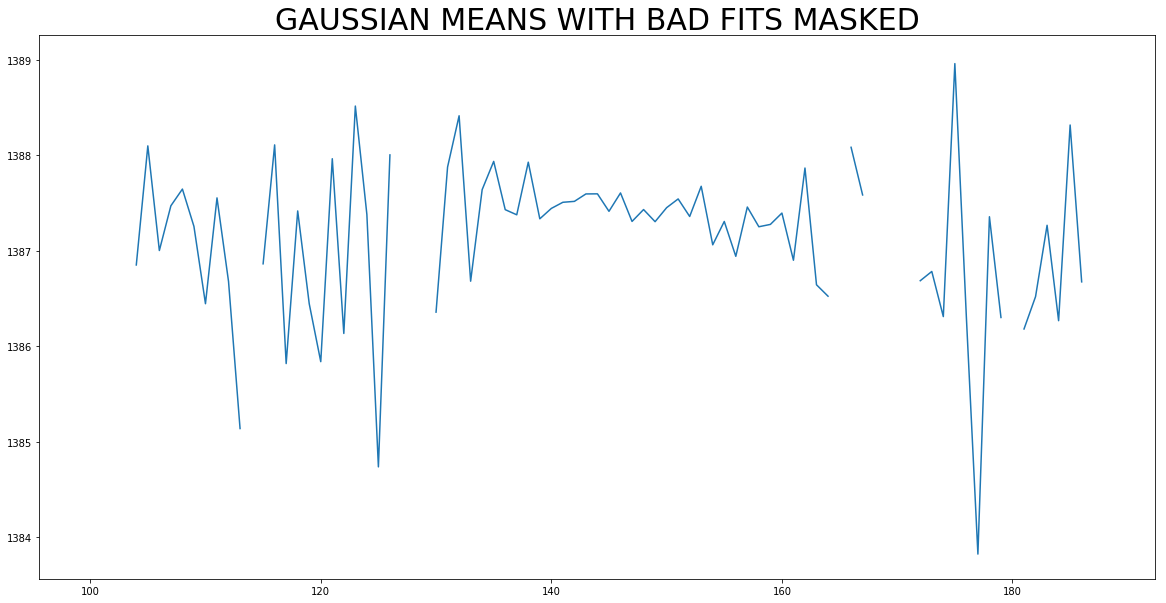

In [102]:
gaussmeans_specpix_fullccd_MASKED = masked_gaussian_means + wl_pix_correction + bestline_range_correction[0]
gaussmax_specpix_fullccd_MASKED = masked_gaussian_means + stddev + wl_pix_correction + bestline_range_correction[0]


plt.figure(figsize=(20,10))
plt.title('GAUSSIAN MEANS WITH BAD FITS MASKED',fontsize=30)
plt.plot(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED)

(1384, 1389)

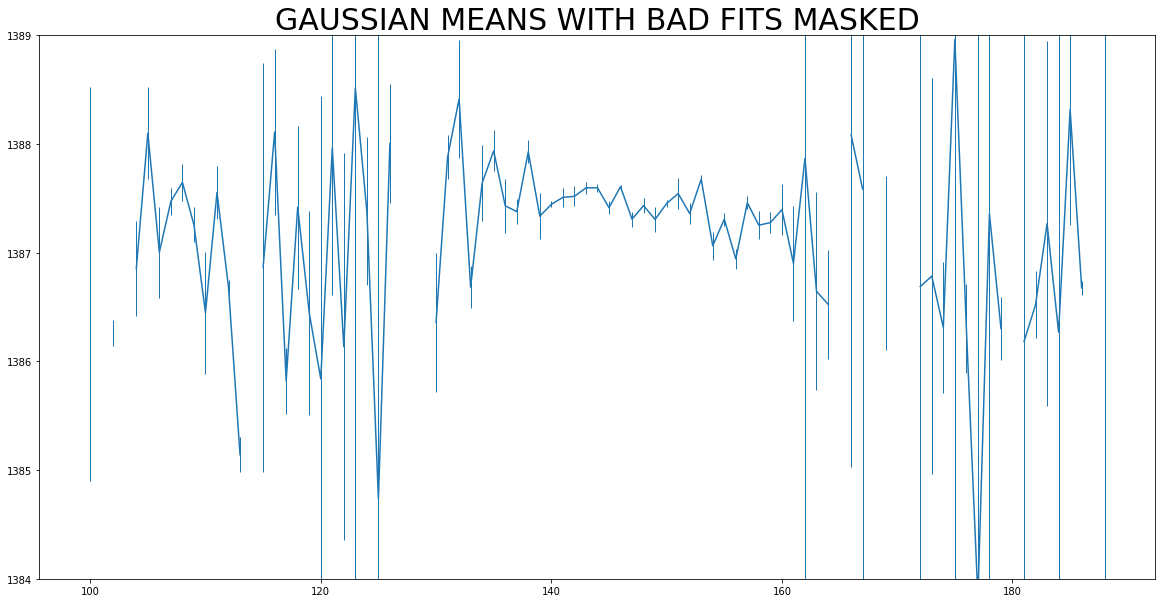

In [103]:
#with error bars


plt.figure(figsize=(20,10))
plt.title('GAUSSIAN MEANS WITH BAD FITS MASKED',fontsize=30)
plt.errorbar(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED,yerr=fullmask_sigma,capsize=0,elinewidth=1) #,alpha=0.5)
plt.ylim(1384,1389)

(1386, 1388)

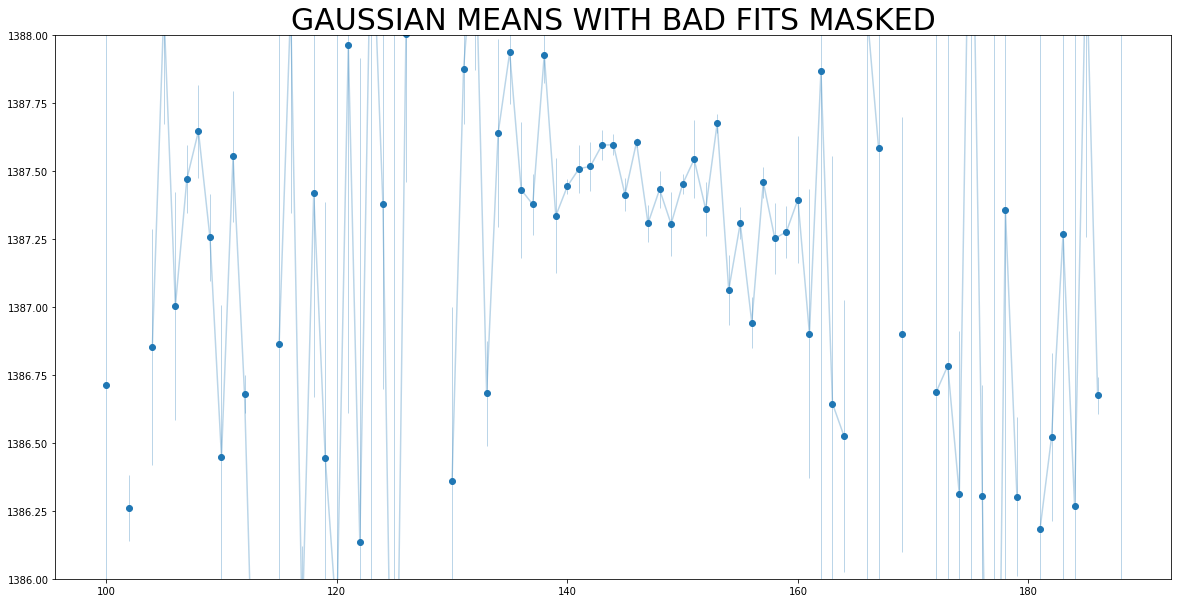

In [104]:
plt.figure(figsize=(20,10))
plt.title('GAUSSIAN MEANS WITH BAD FITS MASKED',fontsize=30)
plt.scatter(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED)
plt.errorbar(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED,yerr=fullmask_sigma,capsize=0,elinewidth=1,alpha=.3)
plt.ylim(1386,1388)#1384,1389)

In [105]:
print(gaussmeans_specpix_fullccd_MASKED)

[1386.71245713           nan 1386.25929607           nan 1386.85220545
 1388.09883721 1387.00344603 1387.47172954 1387.64656548 1387.25594357
 1386.44652678 1387.5543549  1386.68008213 1385.13987597           nan
 1386.86417841 1388.10922369 1385.81996551 1387.41774331 1386.44627759
 1385.83986455 1387.96434047 1386.13515937 1388.51575646 1387.38058278
 1384.73849632 1388.00421561           nan           nan           nan
 1386.35835461 1387.87731682 1388.41406151 1386.68217144 1387.64075254
 1387.93637304 1387.43117898 1387.37735649 1387.92812932 1387.33531355
 1387.44416465 1387.50832171 1387.51787802 1387.59572692 1387.59674655
 1387.41372718 1387.60603627 1387.30792079 1387.43231775 1387.30537263
 1387.45189077 1387.54341015 1387.35982522 1387.67584907 1387.06315369
 1387.3075689  1386.94276509 1387.45865494 1387.25217496 1387.27668102
 1387.39548233 1386.90159123 1387.86688763 1386.64473812 1386.52524729
           nan 1388.08398035 1387.58524317           nan 1386.90040074
      

# apply ds

Text(0.5,1,'h-alpha gaussian means in wl values')

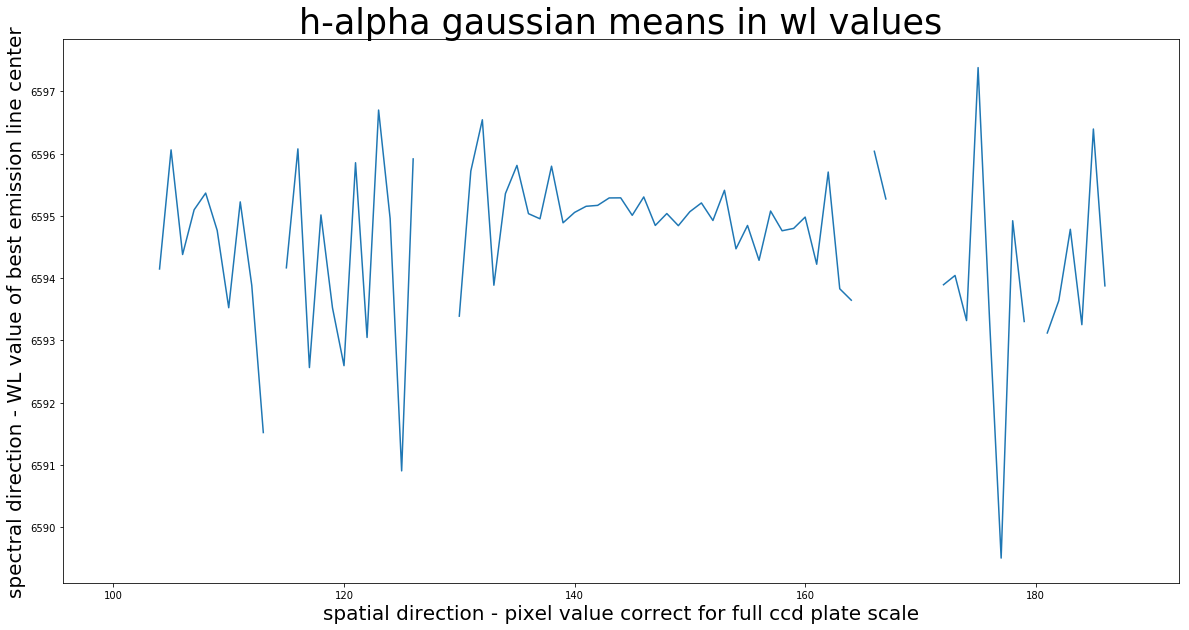

In [106]:
#applies ds


#gotta figure a way to keep masked values masked and not just add to a val from corrections
################################################################
wl_gaussians = np.array(ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED))
#################################################################

#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - WL value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,wl_gaussians)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
##########################################################
plt.title('h-alpha gaussian means in wl values',fontsize=35)
##########################################################
#plt.ylim(6620,6625)
#plt.ylim(6600,6655)
#plt.ylim(6616,6628)

# getting galaxy spectral core pix

In [107]:
#NOTE THAT THIS CELL USES GAUSSIAN VALUES.....IF CENTROIDS HAVE BETTER FIT (less likely) CHANGE IT

#robust way to clean data (to avoid bad g fits)
#################################################################
cleaned_gaussmeans = sigma_clip(masked_gaussian_means, sigma=3)
################################################################
avg_of_gmeans = np.mean(cleaned_gaussmeans)

#correcting avg Ha wl pixel value to reflect its place on the full ccd scale
bestline_corewl_pix_fullccd = avg_of_gmeans + wl_pix_correction + bestline_range_correction[0]
print('pix value of halpha core spectral axis is:',bestline_corewl_pix_fullccd)

#applying ds to get pix to wl value
########################################################################
bestline_core_wl = ds_red.pixtowl(bestline_corewl_pix_fullccd)*u.angstrom
#########################################################################

print('Best emission line "core" wl (based on gaussian fits) is:',bestline_core_wl)

pix value of halpha core spectral axis is: 1387.2481281072678
Best emission line "core" wl (based on gaussian fits) is: 6594.753341384145 Angstrom


In [108]:
wl_gauss_test = ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED)*u.angstrom
wl_gaussians = np.array(ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED))
average = np.nanmean(wl_gauss_test)
#print(wl_gauss_test,'thank you next',wl_gaussians,'average of the averaged',average)
print(average)



6594.59317743606 Angstrom


# getting galaxy spatial core

shape of first section: (91, 10) matches shape of second section: (91, 10)
shape of first section 2d: (91, 1)
shape of second section 2d: (91, 1)
first section centroid y,x: 0.0 49.17443073975424
second section centroid y,x: 0.0 49.125111016691406
This is the average pixel value of the core BEFORE SPATIAL CORRECTIONS 49.149770878222824
Pixel Value of core along spatial axis wrt full CCD size 149.14977087822282


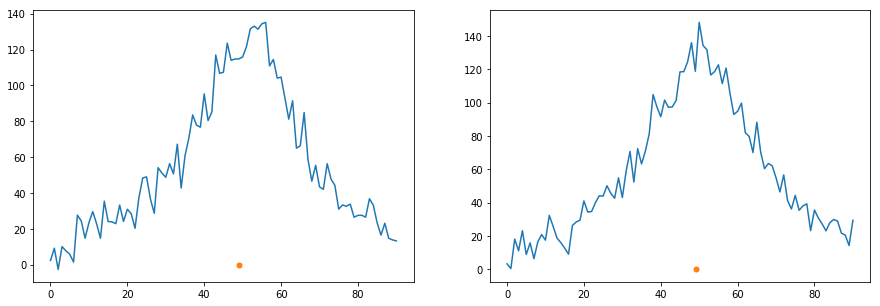

In [109]:
#USING SECTIONS SURROUNDING HALPHA WL RANGE
np.shape(flux_data)#(226,4104) #note that this is missing those wl's


#making arrays surrounding best emission line
################################################
upperha = 1382 #bestline_range_correction[1]
lowerha = 1373 #bestline_range_correction[0]
#################################################
width_sections = 10 #reduced from 50 to 25 to avoid cosmic rays skewing to higher pix side
upper_one = lowerha - 1 #distance to avoid line emission contaminating core determination
lower_one = upper_one - width_sections
lower_two = upperha + 1 #giving it some distance
upper_two = lower_two + width_sections
first_section = flux_data[:,lower_one:upper_one]
second_section = flux_data[:,lower_two:upper_two]
print('shape of first section:', np.shape(first_section), 'matches shape of second section:', np.shape(second_section))


#collapsing both sections in the spatial direction (histogram like)
first_section_sum = np.sum(first_section,axis=1) 
first_section2d = first_section_sum[:,np.newaxis] #2d required to centroid
second_section_sum = np.sum(second_section,axis=1)
second_section2d = second_section_sum[:,np.newaxis] #2d required to centroid
print('shape of first section 2d:', np.shape(first_section2d))
print('shape of second section 2d:', np.shape(second_section2d))


#does the centroiding
y_first, x_first = centroid_com(first_section2d)
y_second, x_second = centroid_com(second_section2d)
print('first section centroid y,x:',x_first,y_first)
print('second section centroid y,x:',x_second,y_second)



#verify by plots
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(first_section2d);
ax2.plot(second_section2d);
#note below had to reverse xy centroids to visualize correctly, not sure why it inverted tho...
ax1.plot(y_first,x_first, '.', markersize=10)
ax2.plot(y_second,x_second, '.', markersize=10)

#averaging the two core values, the y's
core_array = np.array([y_first,y_second])
core_avgcentroids = np.mean(core_array)
print('This is the average pixel value of the core BEFORE SPATIAL CORRECTIONS',core_avgcentroids)

#FULL CCD pixel value of core
core_from_sections = core_avgcentroids + space_pix_correction #corrects for spatial axis target cutout
print('Pixel Value of core along spatial axis wrt full CCD size',core_from_sections)

# converting pix----->kpc

In [110]:
distance_pix_wrtcore_sections = target_spacepix_fullccd - core_from_sections #for core wl using 2 sections around best emission line

In [111]:
#actual converting for loop CENTROIDS pixels to kpc
## good for core defined by 2 sections around halpha

#converts pixels to kpc (distance profile)
arcmins_sections =[]
distances_sections=[]
more_sections = []


#converts pix to kpc and saves as quantity list
for i in distance_pix_wrtcore_sections:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    blueplatescale = 0.389*u.arcsec/u.pixel
    dbsp_pix_equiv_red = u.pixel_scale(redplatescale)
    dbsp_pix_equiv_blue = u.pixel_scale(blueplatescale)
    r_in_pixel = i*u.pixel
    ################################################################
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv_red)
    distance = 25.4*u.Mpc # distance of object (host) from us
    ###############################################################
    rad_to_arcmin = (1*u.rad).to('arcmin')
    r_in_kpc = ((r_in_arcmin/rad_to_arcmin)*distance).to("kpc") #gets radians*distancefromus for gal width in kpc
    more_sections = r_in_kpc #/ (1*u.kpc)
    distances_sections.append(more_sections.value)
distances_sections = np.array(distances_sections)

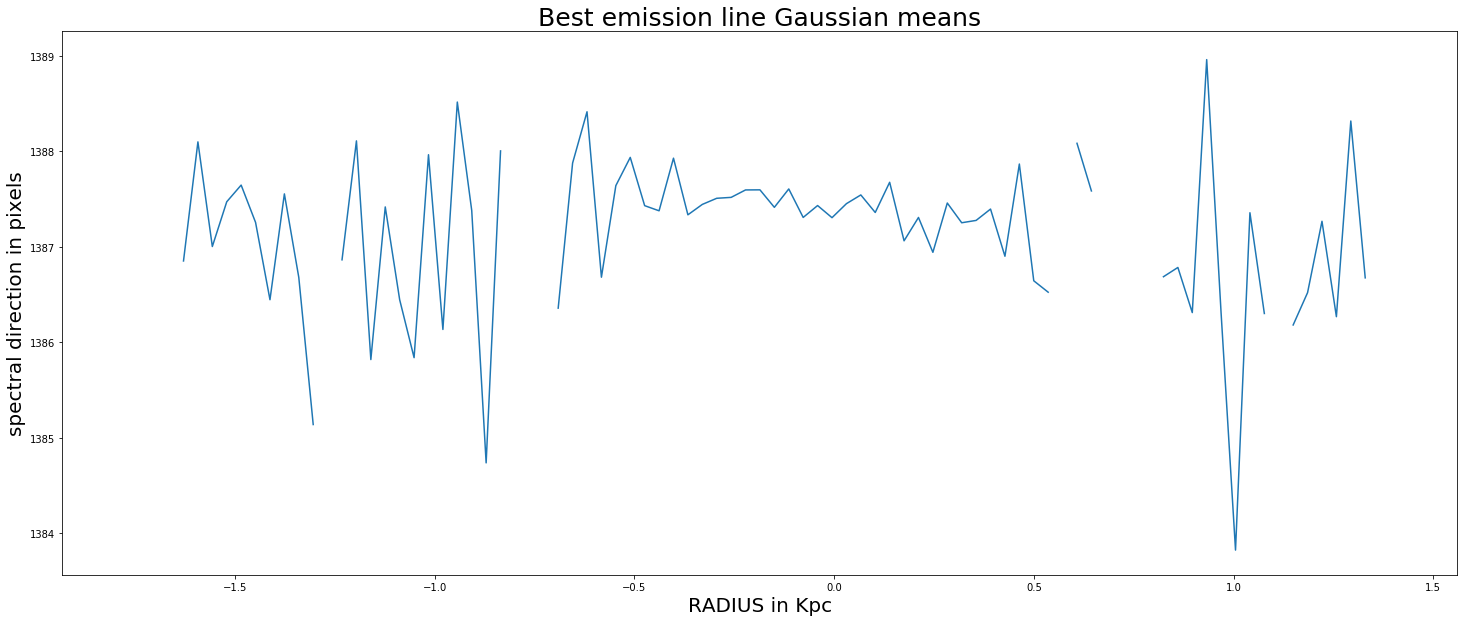

In [112]:
#GAUSSIAN MEANS plot with pix-wls & kpc

plt.figure(figsize=(25,10))
plt.title('Best emission line Gaussian means', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in pixels',fontsize=20)
plt.plot(distances_sections * u.kpc, gaussmeans_specpix_fullccd_MASKED)

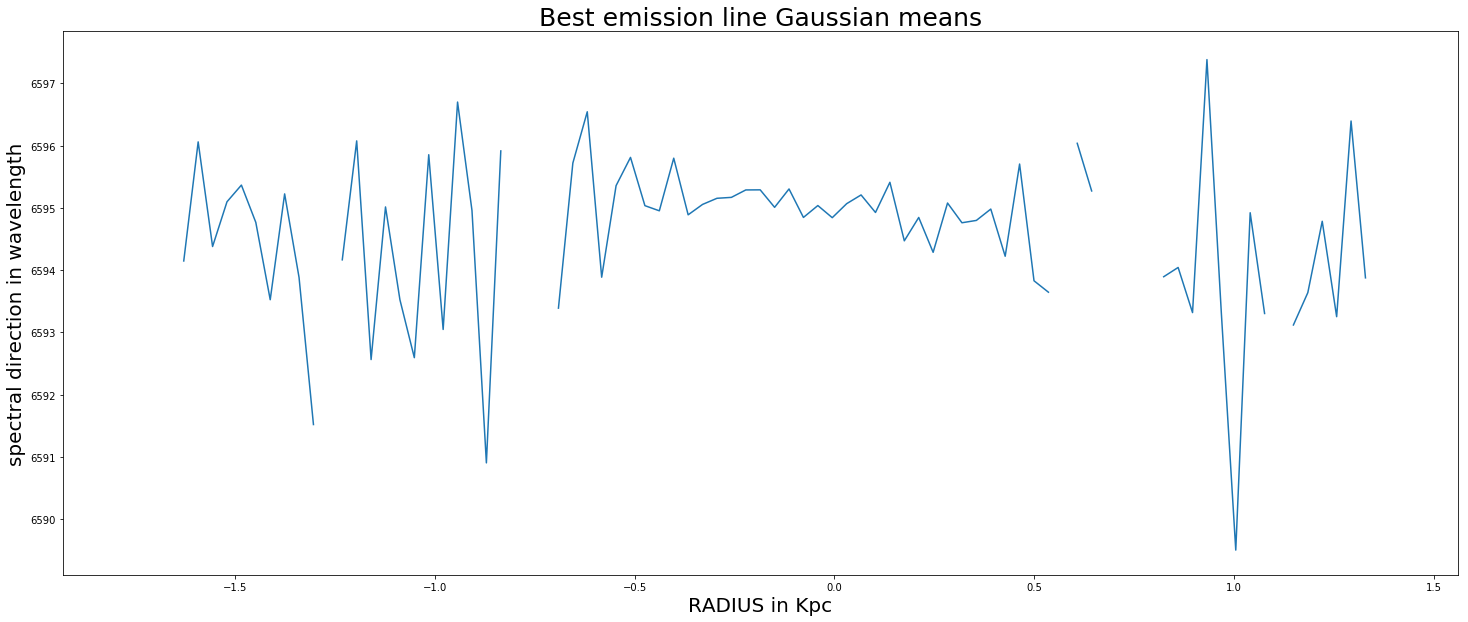

In [113]:
#GAUSSIAN MEANS plot with wl & kpc

plt.figure(figsize=(25,10))
plt.title('Best emission line Gaussian means', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in wavelength',fontsize=20)
plt.plot(distances_sections * u.kpc, wl_gaussians)

In [114]:
### doesnt rely on distance from core



distances_sections_target=[]
more_sections_target = []

#converts pix to kpc and saves as quantity list
for i in target_spacepix_fullccd:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    blueplatescale = 0.389*u.arcsec/u.pixel
    dbsp_pix_equiv_red = u.pixel_scale(redplatescale)
    dbsp_pix_equiv_blue = u.pixel_scale(blueplatescale)
    r_in_pixel = i*u.pixel
    ################################################################
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv_red)
    distance = 25.4*u.Mpc # distance of object (host) from us
    ###############################################################
    rad_to_arcmin = (1*u.rad).to('arcmin')
    r_in_kpc = ((r_in_arcmin/rad_to_arcmin)*distance).to("kpc") #gets radians*distancefromus for gal width in kpc
    more_sections_target = r_in_kpc #/ (1*u.kpc)
    distances_sections_target.append(more_sections_target.value)
distances_sections_target = np.array(distances_sections_target)

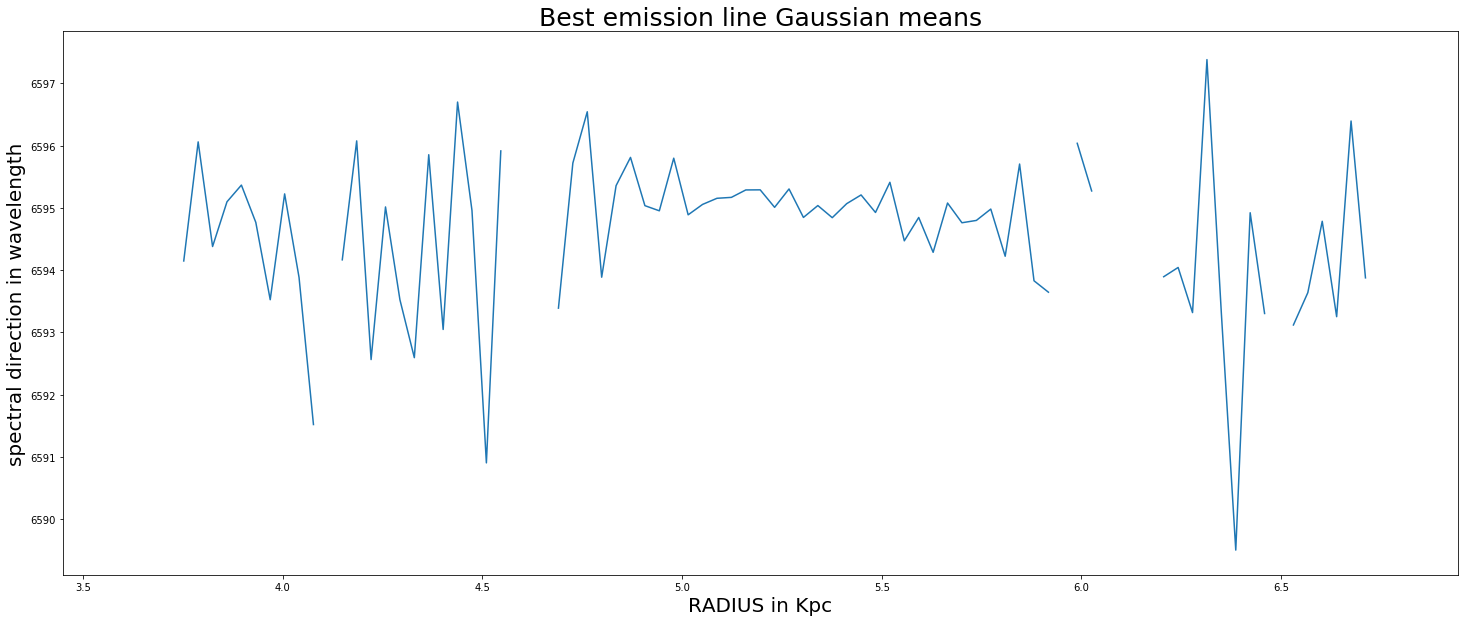

In [115]:
#GAUSSIAN MEANS plot with wl & kpc.....NO SPATIAL CORE from sections used

plt.figure(figsize=(25,10))
plt.title('Best emission line Gaussian means', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in wavelength',fontsize=20)
plt.plot(distances_sections_target * u.kpc, wl_gaussians)

# converting pix---->wl -----> velocity

In [116]:
#convert pix to wl via ds
###################################################################
#centroids_wl = ds_red10.pixtowl(centroid_specpix_fullccd)*u.angstrom
gauss_meanWstd_wl  = ds_red.pixtowl(gaussmax_specpix_fullccd_MASKED)*u.angstrom
gauss_means_wl = ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED)*u.angstrom
#core_wl_sections = ds_red.pixtowl(core_from_sections)*u.angstrom
####################################################################

In [117]:
#using redshift formula to get velocity

#((obs_wl - true_wl)/true_wl)* c = velocity
#except what we want is  v_not relative to core - v_of core

#velocities NOT yet relative to the core
##############################################################################
v_spec_gaussians = ((gauss_means_wl/(6563*u.angstrom)) -1) * const.c #gaussian velocities
#v_spec_centroids = (centroids_wl /(6563*u.angstrom) -1) * const.c #centroid velocities
#v_core = ((bestline_core_wl/(6563*u.angstrom)) -1) * const.c #core velocity
v_core = ((average/(6563*u.angstrom)) -1) * const.c #core velocity
#v_core uses average val of gaussmeans_specpix_fullccd_MASKED passed into ds(so more like normalizing)

###############################################################################

#velocities relative to the core from sections
y_axis_Gvelocity = (v_spec_gaussians - v_core).to('km/s')  #gaussian
#y_axis_Cvelocity = (v_spec_centroids - v_core).to('km/s') #centroids

print("velocity of best emission line's spectral 'core':",v_core.to('km/s'), len(y_axis_Gvelocity),y_axis_Gvelocity)

velocity of best emission line's spectral 'core': 1443.1504372369861 km / s 91 [ -30.21597924           nan  -61.96682605           nan  -20.42444367
   66.92211527   -9.82768002   22.98300592   35.23308064    7.86375529
  -48.84847767   28.7722404   -32.48434694 -140.39858622           nan
  -19.58555136   67.6498601   -92.74848041   19.20040517  -48.86593706
  -91.35425915   57.49840075  -70.66446825   96.13427431   16.59671619
 -168.52086167   60.29231057           nan           nan           nan
  -55.02627758   51.40096732   89.0088315   -32.33795911   34.82578955
   55.53882315   20.14178917   16.37066314   54.9612152    13.42488438
   21.05164349   25.54687509   26.21644805   31.67101749   31.74245942
   18.91901108   32.39335411   11.50558532   20.22157828   11.32704623
   21.59298202   28.00538444   15.1423175    37.28486982   -5.64422159
   11.48092977  -14.07932905   22.06692025    7.59970405    9.31674289
   17.64066741  -16.96420113   50.67023153  -34.96073908  -43.3329045

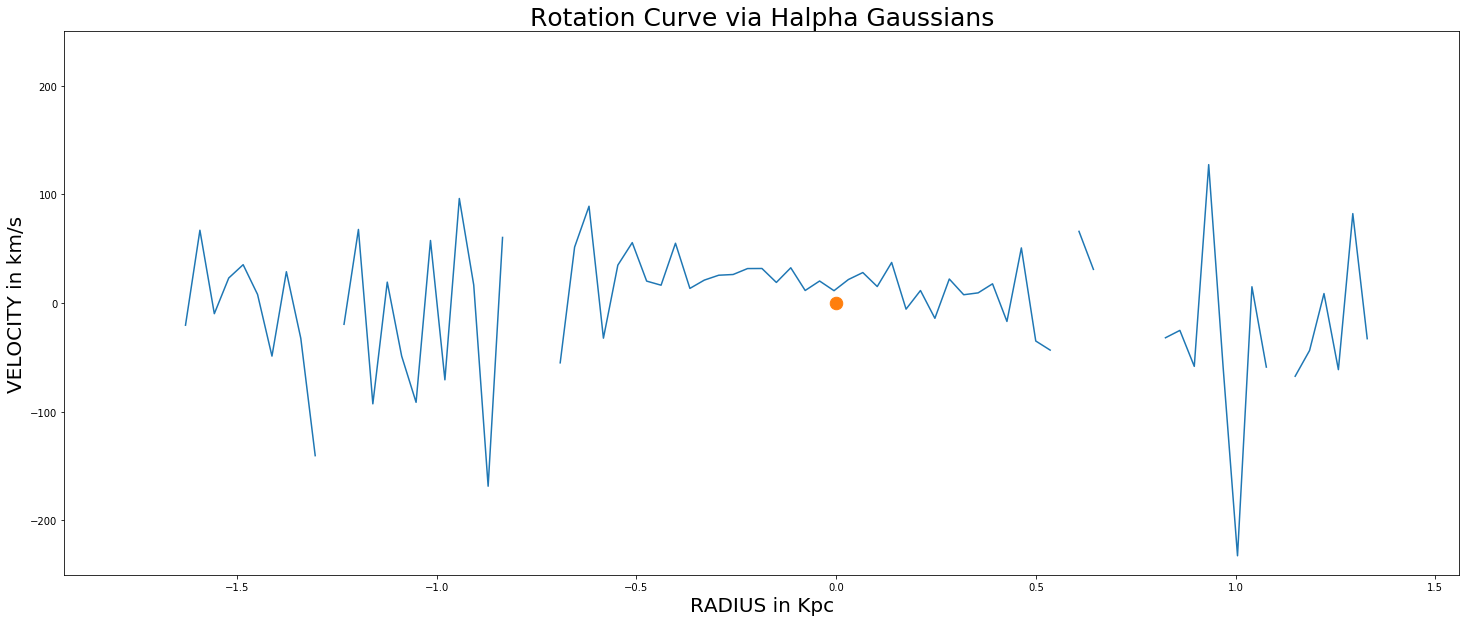

In [118]:
# used core from sections

plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.plot(distances_sections * u.kpc, y_axis_Gvelocity)
plt.ylim(-250,250) #adjust as needed to center around zero
plt.plot(0,0,'.', markersize=25)

# error bars

In [119]:
#newer way trying to get core from eriks model

########################################### fullmask_sigma is in pixels
sigma_gauss_pix = np.sqrt(np.abs(fullmask_sigma)) #taking sqrt of unc to get a true sigma
################################################
#correct to full ccd pix scale
#print(sigma_gauss_pix)
means_Wsigma_fullccd = masked_gaussian_means + sigma_gauss_pix + wl_pix_correction + bestline_range_correction[0]
#apply ds
means_max_wl = ds_red.pixtowl(means_Wsigma_fullccd)*u.angstrom


#making into velocities
v_means_withsigma = (means_max_wl/ (6563*u.angstrom)-1) * const.c #be sure to check all values ok (no inf)
#in converting pix2wl2vel section...already did same steps for means w/o sigma


#extracting sigma velocity
v_unc = (v_means_withsigma - v_spec_gaussians).to('km/s') 
#print(np.shape(v_unc))
#np.reshape(v_unc,(226,))
print('v_unc', np.shape(v_unc))#make sure its same length as y_axis_Gvelocitys_unc

v_unc (91,)


In [120]:
dist_kpc = distances_sections * u.kpc

(-250, 250)

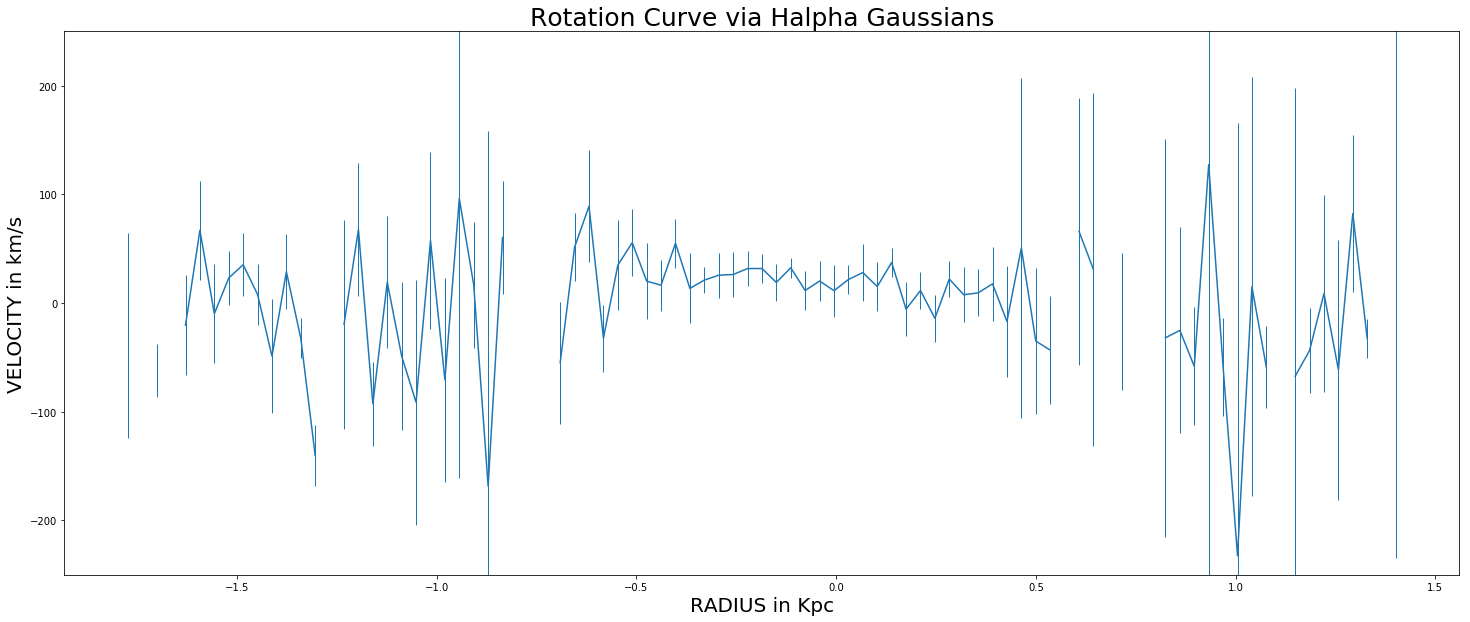

In [121]:
plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.errorbar(np.asarray(dist_kpc), np.asarray(y_axis_Gvelocity),yerr=np.asarray(v_unc),elinewidth=1)
plt.ylim(-250,250) #adjust as needed to center around zero
#plt.plot(0,0,'.', markersize=25)

(-250, 250)

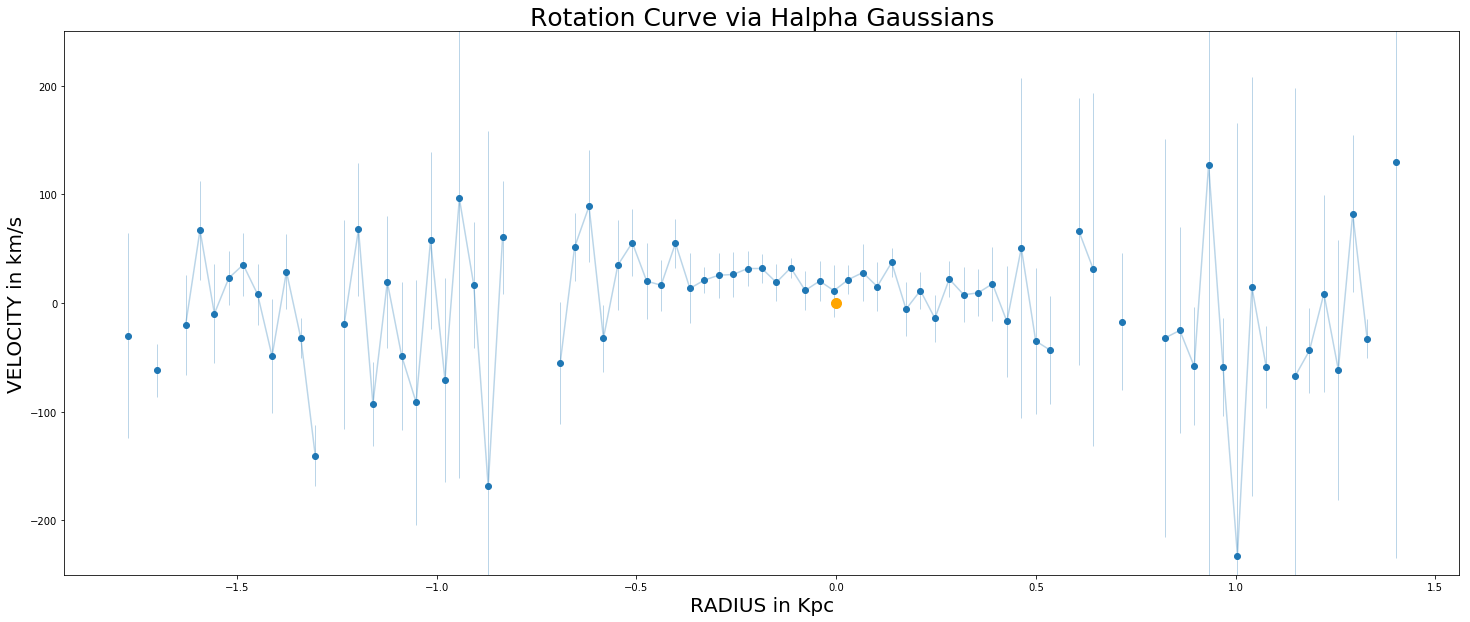

In [122]:
plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.scatter(distances_sections * u.kpc, y_axis_Gvelocity)
plt.plot(0,0,'.', markersize=20,color='orange')
plt.errorbar(np.asarray(distances_sections * u.kpc), np.asarray(y_axis_Gvelocity),yerr=np.asarray(v_unc),elinewidth=1,alpha=0.3)
plt.ylim(-250,250) #adjust as needed to center around zero
#plt.plot(0,0,'.', markersize=25)

# mass modeling

In [123]:
# needed this to actually make the model do a fit
arr=np.asarray
# nan_msk = ~np.isnan(v_unc)
# m = fit(m_init, arr(distances_sections)[nan_msk], arr(y_axis_Gvelocity.value)[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))

Model: eriksmodel
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Parameters:
    r_cen       alpha        ...       sigma               omega       
    ----- ------------------ ... ------------------ -------------------
      0.0 28.777132860994826 ... -62.58200079266483 0.08442532910077033


(-200, 200)

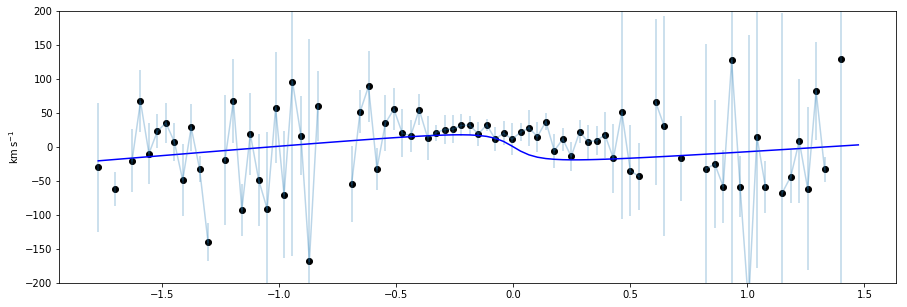

In [124]:
#uses core from sections
#eriks model eqt 5



@models.custom_model #very necessary line
def eriksmodel(r, r_cen=0, alpha=.00001, beta=.00001, sigma=50, omega=.3):
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)



#fit model to data
m_init = eriksmodel()
fit = fitting.LevMarLSQFitter()
nan_msk = ~np.isnan(v_unc)
m = fit(m_init, arr(distances_sections)[nan_msk], arr(y_axis_Gvelocity.value)[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))

print(m)

#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections,y_axis_Gvelocity, color='k')
plt.errorbar(distances_sections, y_axis_Gvelocity, yerr=v_unc,alpha=.3)
########################################################################
plt.plot(distances_sections, m(distances_sections), color='b')
plt.ylim(-200,200) #zooms to see data good, if fit is good

Model: eriksmodel
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Parameters:
          alpha              beta        ...       omega             v_offset     
    ----------------- ------------------ ... ------------------ ------------------
    48.75817713833379 -47.35935606573914 ... 0.2437309684072641 28.505481840635365


(-200, 200)

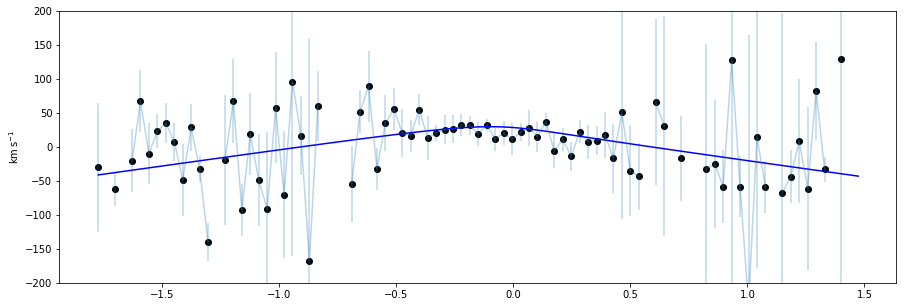

In [125]:
# added in a v-offset 

#uses core from sections
#eriks model eqt 5



@models.custom_model #very necessary line
def eriksmodel(r, alpha=.00001, beta=.00001, sigma=50, omega=.3,v_offset=0):
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)+v_offset


#fit model to data
m_init = eriksmodel()
fit = fitting.LevMarLSQFitter()
nan_msk = ~np.isnan(v_unc)
m = fit(m_init, arr(distances_sections)[nan_msk], arr(y_axis_Gvelocity.value)[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))

print(m)

#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections,y_axis_Gvelocity, color='k')
plt.errorbar(distances_sections, y_axis_Gvelocity, yerr=v_unc,alpha=.3)
########################################################################
plt.plot(distances_sections, m(distances_sections), color='b')
plt.ylim(-200,200) #zooms to see data good, if fit is good

Model: eriksmodel
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Parameters:
    r_cen alpha  beta       sigma       omega     v_offset    
    ----- ----- ----- ----------------- ----- ----------------
      5.0 1e-07 1e-07 30.81762881421662   0.0 9.56099809994616


/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


(-200, 200)

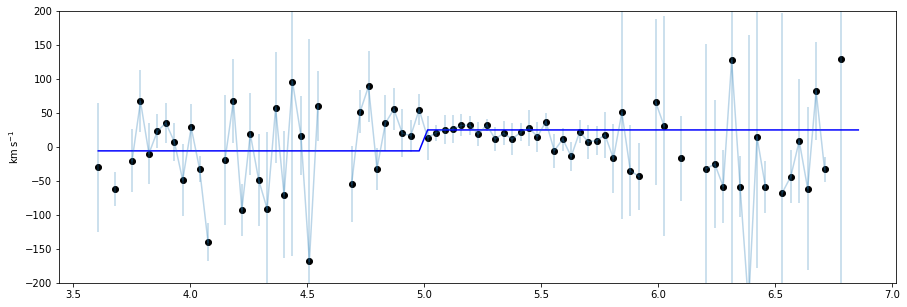

In [126]:
# added in a v-offset & dr b/c v-offset didnt do enough

#uses core from sections
#eriks model eqt 5



@models.custom_model #very necessary line
def eriksmodel(r,r_cen=0, alpha=.00001, beta=.00001, sigma=2, omega=5,v_offset=0):
    dr = r-r_cen
    return (dr * ((alpha + beta)/2) + (sigma - dr*(alpha - beta)) * (np.arctan(dr / omega))/np.pi)+v_offset

# setting bounds
m_init = eriksmodel(bounds={'r_cen': (5,6), 'alpha':(.01,.0000001), 'beta':(.01,.0000001),'sigma': (0,100),'omega':(0,100)})
m_init.r_cen=5.35

#fit model to data
fit = fitting.LevMarLSQFitter()
nan_msk = ~np.isnan(v_unc)
m = fit(m_init, arr(distances_sections_target)[nan_msk], arr(y_axis_Gvelocity.value)[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))

print(m)

#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections_target,y_axis_Gvelocity, color='k')
plt.errorbar(distances_sections_target, y_axis_Gvelocity, yerr=v_unc,alpha=.3)
########################################################################
plt.plot(distances_sections_target, m(distances_sections_target), color='b')
plt.ylim(-200,200) #zooms to see data good, if fit is good

In [127]:
#len(distances_sections_target),y_axis_Gvelocity, v_unc

# nan_msk = ~np.isnan(v_unc)

# print(type(nan_msk))
# print(len(nan_msk))
# print(nan_msk)
# print(type(v_unc))
# print(len(v_unc),v_unc)
# print(arr(distances_sections_target))
# print(len(arr(distances_sections_target)[nan_msk]))
# print(arr(distances_sections_target)[nan_msk])

#type(nan_msk2),nan_msk2
#arr(distances_sections_target)[nan_msk]
#arr(y_axis_Gvelocity.value)[nan_msk]
#1/(v_unc.value[nan_msk])**2

# 2D spec & model overlay

In [128]:
# type(gauss_means_wl),type(means_Wsigma_fullccd), gauss_means_wl.unit
# #len(gaussmeans_specpix_fullccd_MASKED)
# y_unc_pixs = means_Wsigma_fullccd - gaussmeans_specpix_fullccd_MASKED
# len(y_unc_pixs)

(1383, 1390)

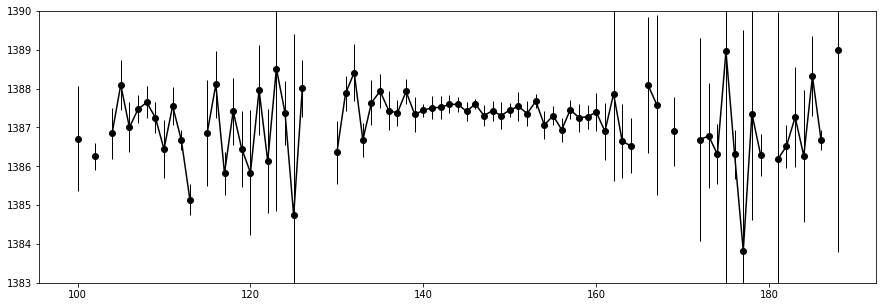

In [129]:
#in pixel space


y_unc_pixs = means_Wsigma_fullccd - gaussmeans_specpix_fullccd_MASKED #needed errors in pixs


plt.figure(figsize=(15,5))
plt.scatter(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED, color='k')
plt.errorbar(target_spacepix_fullccd, gaussmeans_specpix_fullccd_MASKED, yerr=y_unc_pixs,elinewidth=1,color='k')
plt.ylim(1383,1390)

In [130]:
# twod=subimg2.data[100:191,1383:1392] #[:,1386:1397]#[space,wl]for RED [wl,space]for BLUE
# #conclusions
# bestline_range_fullccd = (1383, 1392)
# bestline_range_correction = (1373,1382) 
# #################################################################

# vmin=-10
# vmax=45
# plt.figure(figsize=(15,5))
# plt.imshow(twod.T,vmin=vmin,vmax=vmax)
# plt.ylabel('wl (in pix)')
# plt.xlabel('spatial pix')


In [131]:
#len(gaussmeans_specpix_fullccd_MASKED),len(target_spacepix_fullccd),twod.shape #so [space,wl]

In [132]:
#twod[::,0] #all the flux values from 1st spatial row

(80, 200)

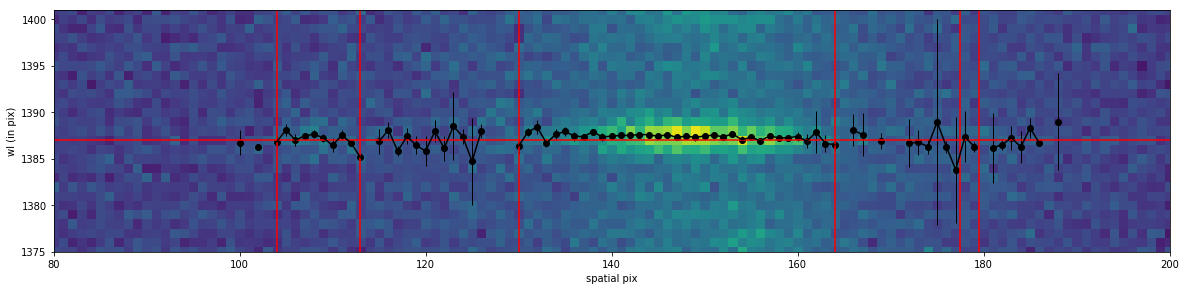

In [133]:
#in pixel space


y_unc_pixs = means_Wsigma_fullccd - gaussmeans_specpix_fullccd_MASKED #needed errors in pixs
subimg_fullccd =subimg2.data

vmin=-10
vmax=45
plt.figure(figsize=(20,10))
plt.imshow(subimg_fullccd.T,vmin=vmin,vmax=vmax)
plt.ylabel('wl (in pix)')
plt.xlabel('spatial pix')
plt.scatter(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED, color='k')
plt.errorbar(target_spacepix_fullccd, gaussmeans_specpix_fullccd_MASKED, yerr=y_unc_pixs,elinewidth=1,color='k')
plt.ylabel('wl (in pix)')
plt.xlabel('spatial pix')
plt.axvline(113,color='r')
plt.axvline(104,color='r')
plt.axvline(130,color='r')
plt.axvline(164,color='r')
plt.axvline(177.5,color='r')
plt.axvline(179.5,color='r')
plt.axhline(1387,color='r')
plt.ylim(1375,1401)
plt.xlim(80,200)

(-10, 20)

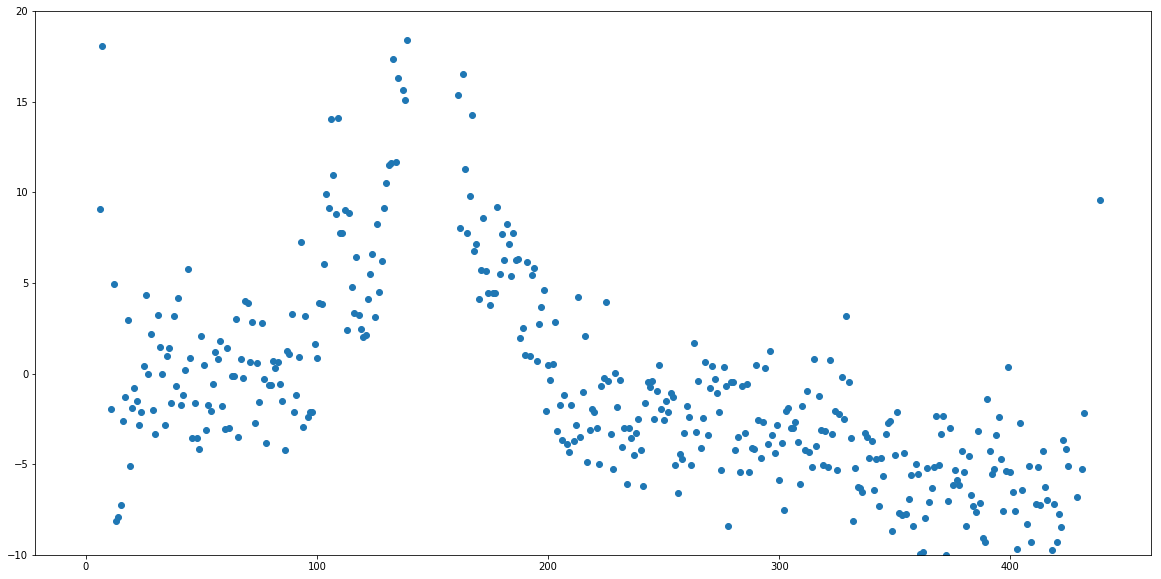

In [134]:
plt.figure(figsize=(20,10))
plt.scatter(np.arange(0,len(subimg_fullccd[::,1387])),subimg_fullccd[::,1387])
plt.ylim(-10,20)

(80, 200)

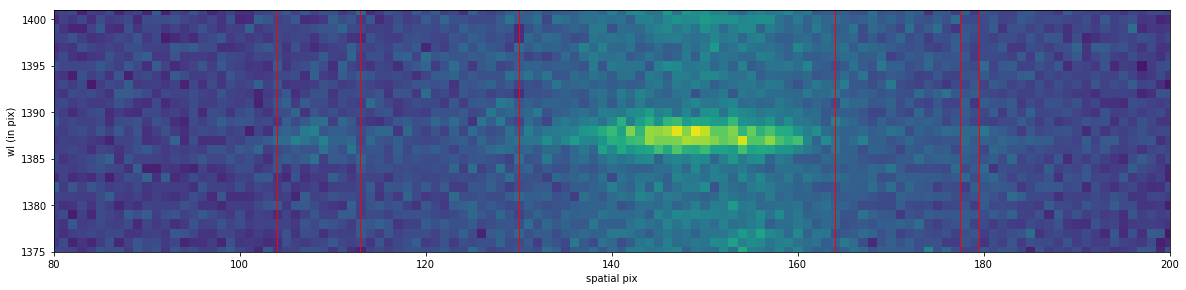

In [135]:
vmin=-10
vmax=45
plt.figure(figsize=(20,10))
plt.imshow(subimg_fullccd.T,vmin=vmin,vmax=vmax)
plt.ylabel('wl (in pix)')
plt.xlabel('spatial pix')
plt.ylabel('wl (in pix)')
plt.xlabel('spatial pix')
plt.axvline(113,color='r',lw=1)
plt.axvline(104,color='r',lw=1)
plt.axvline(130,color='r',lw=1)
plt.axvline(164,color='r',lw=1)
plt.axvline(177.5,color='r',lw=1)
plt.axvline(179.5,color='r',lw=1)
plt.ylim(1375,1401)
plt.xlim(80,200)

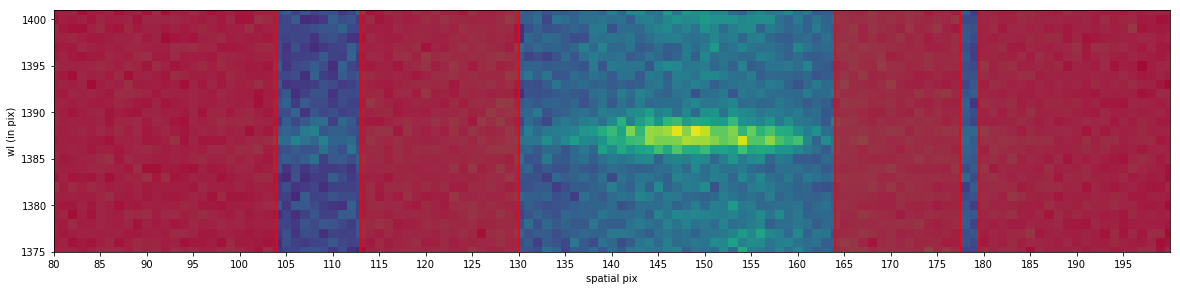

In [136]:
#in pixel space---seeing regions w/o HII to mask by eye


y_unc_pixs = means_Wsigma_fullccd - gaussmeans_specpix_fullccd_MASKED #needed errors in pixs
subimg_fullccd =subimg2.data

vmin=-10
vmax=45
fig, ax = plt.subplots(1,figsize=(20,10))
ax.imshow(subimg_fullccd.T,vmin=vmin,vmax=vmax);
ax.set_ylabel('wl (in pix)')
ax.set_xlabel('spatial pix')
ax.axvline(113,color='r')
ax.axvline(104,color='r')
ax.axvline(130,color='r')
ax.axvline(164,color='r')
ax.axvline(177.5,color='r')
ax.axvline(179.5,color='r')

ax.axvspan(80, 104, alpha=0.5, color='red')
ax.axvspan(113, 130, alpha=0.5, color='red')
ax.axvspan(164, 177.5, alpha=0.5, color='red')
ax.axvspan(179.5, 200, alpha=0.5, color='red')
ax.set_ylim(1375,1401)#1384,1390)
ax.set_xlim(80,200)
ax.set_xticks(np.arange(80, 200, 5.0));

# Masking poor fit regions - in case our errors are underestimated

In [137]:
#collecting relevant info

#arrays converted to real world
#distances_sections_target,y_axis_Gvelocity, v_unc

#in full ccd pix want to mask these space[idx]
mask_reg1 = (0,104)
mask_reg2 =(113,130)
mas_reg3 = (164,177)
mask_reg4 = (179.5,190)

#pix arr corresponding to full ccd for real world arrays
pix_arr_ps = np.arange(np.min(target_spacepix_fullccd),np.max(target_spacepix_fullccd)+1,1)
print('arr values:', pix_arr_ps)


#converting bad fit idx from target pix space to full ccd pix space
bad_idx_fullccd = all_bad_idxs + space_pix_correction
bad_idx_fullccd

arr values: [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190]


array([101, 103, 114, 127, 128, 129, 165, 168, 170, 171, 180, 187, 189,
       190])

In [138]:
#connecting pix arrs from pix space to real world


pix_arr_rw =[]
for count,arr in enumerate(pix_arr_ps):
   # print(arr)
    arr = int(arr)
    if  arr <= 104: #region 1
        count = np.nan
    elif arr >= 113 and arr <=130: #region 2
        count = np.nan
    elif arr >= 164 and arr <= 175: #region 3 
        count = np.nan
    elif arr >= 177 and arr <=178: #extra region to include 1 more good but exclude 2 bad
        count = np.nan
    elif arr >= 180: #region 4
        count = np.nan
    elif arr in bad_idx_fullccd: #original bad fits 
        count = np.nan
    else:
        count = count
    pix_arr_rw.append(count)
pix_arr_rw_msk = np.asarray(pix_arr_rw)
pix_arr_rw_msk,len(pix_arr_rw_msk)

(array([nan, nan, nan, nan, nan,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 76., nan,
        nan, 79., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 91)

# Trying mass modeling with masked regions

Model: eriksmodel
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Parameters:
    r_cen alpha  beta       sigma       omega      v_offset    
    ----- ----- ----- ----------------- ----- -----------------
      4.7 1e-09 1e-09 34.68488016277146   0.0 9.234188557899508


/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


(-75, 100)

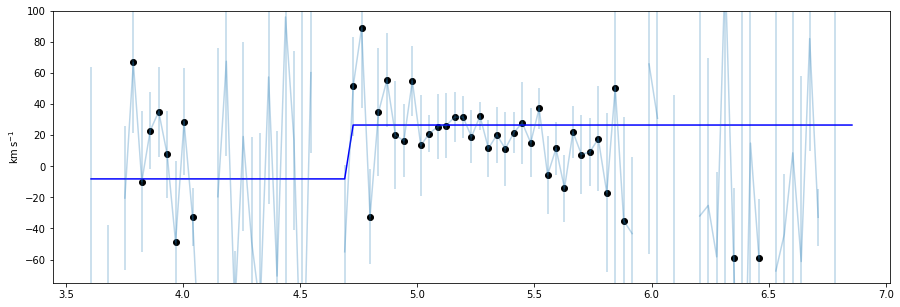

In [139]:
# added in a v-offset & dr b/c v-offset didnt do enough


#uses core from sections
#eriks model eqt 5
@models.custom_model #very necessary line
def eriksmodel(r,r_cen=0, alpha=.00001, beta=.00001, sigma=-20, omega=.05,v_offset=0):
    dr = r-r_cen
    return (dr * ((alpha + beta)/2) + (sigma - dr*(alpha - beta)) * (np.arctan(dr / omega))/np.pi)+v_offset

# setting bounds
m_init = eriksmodel(bounds={'r_cen': (4.7,5.7), 'alpha':(.01,.000000001), 'beta':(.01,.000000001),'sigma': (-300,300),'omega':(0,100)})
m_init.r_cen=5.35
m_init.sigma=10

#fit model to data
fit = fitting.LevMarLSQFitter()
nan_msk2 = ~np.isnan(pix_arr_rw_msk)
m = fit(m_init, distances_sections_target[nan_msk2], y_axis_Gvelocity.value[nan_msk2],weights=(1/(v_unc.value[nan_msk2])**2))
print(m)
#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections_target[nan_msk2],y_axis_Gvelocity[nan_msk2], color='k')
plt.errorbar(distances_sections_target, y_axis_Gvelocity, yerr=v_unc,alpha=.3)
########################################################################
plt.plot(distances_sections_target, m(distances_sections_target), color='b')
#plt.ylim(0,40) #zooms to see data good, if fit is good
#plt.ylim(-200,200)
plt.ylim(-75,100)

In [140]:
len(distances_sections_target),len(distances_sections_target[nan_msk2]),len(nan_msk2)

(91, 43, 91)

Text(0.5,1,'verifying masked correct points, this is in pix space')

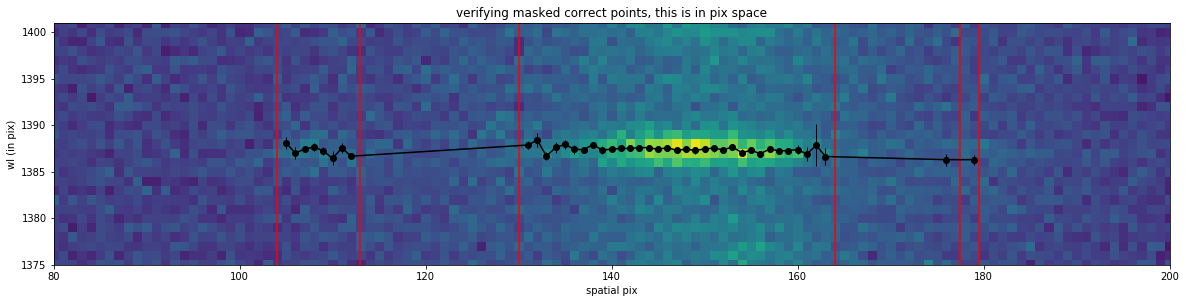

In [141]:
#keep this added in 2nd to last point
#back in pix space to verify masked correct pts

y_unc_pixs = means_Wsigma_fullccd - gaussmeans_specpix_fullccd_MASKED #needed errors in pixs
subimg_fullccd =subimg2.data

vmin=-10
vmax=45
plt.figure(figsize=(20,10))
plt.imshow(subimg_fullccd.T,vmin=vmin,vmax=vmax)
plt.ylabel('wl (in pix)')
plt.xlabel('spatial pix')
plt.scatter(target_spacepix_fullccd[nan_msk2],gaussmeans_specpix_fullccd_MASKED[nan_msk2], color='k')
plt.errorbar(target_spacepix_fullccd[nan_msk2], gaussmeans_specpix_fullccd_MASKED[nan_msk2], yerr=y_unc_pixs[nan_msk2],elinewidth=1,color='k')
plt.ylabel('wl (in pix)')
plt.xlabel('spatial pix')
plt.axvline(113,color='r')
plt.axvline(104,color='r')
plt.axvline(130,color='r')
plt.axvline(164,color='r')
plt.axvline(177.5,color='r')
plt.axvline(179.5,color='r')
plt.ylim(1375,1401)
plt.xlim(80,200)
plt.title('verifying masked correct points, this is in pix space')




# Binning attempt

In [142]:
myt = Table([pix_arr_rw_msk,distances_sections_target, y_axis_Gvelocity, v_unc],names=('pix','space','vel','unc'))
print(len(myt['pix']))
binrange = myt[0:15]
myt[:15]

91


pix,space,vel,unc
,,km / s,km / s
float64,float64,float64,float64
nan,3.6080803775533883,-30.215979241732274,94.37479415688011
nan,3.6441611813289216,nan,nan
nan,3.680241985104456,-61.966826045510594,24.354953900885768
nan,3.7163227888799897,nan,nan
nan,3.7524035926555235,-20.42444366641878,46.17877097200928
5.0,3.7884843964310573,66.92211526935269,45.67377287057112
6.0,3.824565200206592,-9.827680019124644,45.370649623053616
7.0,3.860646003982125,22.98300592256221,24.810021400158295


In [143]:
#bins full table
pix = np.linspace(0., len(myt)-1, len(myt))
bins = np.trunc(pix / 2)
t_grouped = myt.group_by(bins)
t_binned = t_grouped.groups.aggregate(np.mean) #note not accurate for errors!
t_binned[-20:]

pix,space,vel,unc
,,km / s,km / s
float64,float64,float64,float64
52.5,5.5023225757689165,26.213593660027605,17.581346584169545
54.5,5.574484183319985,2.9183540911553427,21.067356702234246
56.5,5.646645790871053,3.9937956001888972,19.211670696723857
58.5,5.71880739842212,8.458223469238263,23.4557732749962
60.5,5.790969005973188,0.33823314069397803,42.457706382382085
62.5,5.863130613524255,7.854746223788009,111.69257969356526
nan,5.935292221075324,nan,nan
nan,6.007453828626391,48.40880429796828,142.47935063883813


In [144]:
#bins only first HII knot
pix2 = np.linspace(0., len(binrange[1:]), len(binrange[1:]))
print('len:', len(pix2),len(binrange[1:]))
bins2 = np.trunc(pix2 / 2)
ts_grouped = binrange[1:].group_by(bins2)
ts_binned = ts_grouped.groups.aggregate(np.mean) #note not accurate for errors!
print('newlen:',len(ts_binned))

# replacing binned first knot in original masked gmeans array
firstknotbinned_t = vstack([ts_binned,myt[15:]])
msk_axis = ~np.isnan(firstknotbinned_t['pix'])
x_axis = firstknotbinned_t['space']
y_axis = firstknotbinned_t['vel']
unc_axis = firstknotbinned_t['unc']

len: 14 14
newlen: 8


In [145]:
msk_axis

array([False, False,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False])

In [146]:
nan_msk3 = ~np.isnan(t_binned['pix'])
distances_section_binned = t_binned['space']
y_axis_Gvelocity_binned = t_binned['vel']
v_unc_binned = t_binned['unc']

In [147]:
pix_arr_rw_msk,len(pix_arr_rw_msk),nan_msk3,len(nan_msk3)

(array([nan, nan, nan, nan, nan,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 76., nan,
        nan, 79., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 91,
 array([False, False, False,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False]),
 46)

Model: eriksmodel
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Parameters:
          r_cen       alpha  beta       sigma        omega      v_offset     
    ----------------- ----- ----- ------------------ ----- ------------------
    5.575767935846657 1e-09 1e-09 -28.86160385303176   0.1 12.207524253104017
black points are the binned point; orange is originally masked array


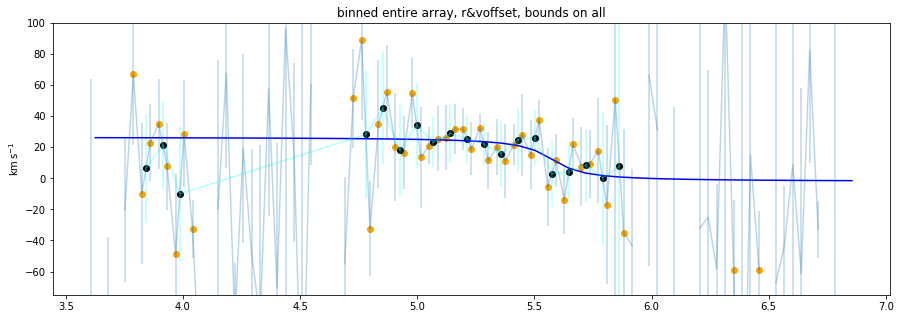

In [148]:
#uses fully binned table
# added in a v-offset & dr b/c v-offset didnt do enough


#eriks model eqt 5
@models.custom_model #very necessary line
def eriksmodel(r,r_cen=0, alpha=.00001, beta=.00001, sigma=-120, omega=.05,v_offset=0):
    dr = r-r_cen
    return (dr * ((alpha + beta)/2) + (sigma - dr*(alpha - beta)) * (np.arctan(dr / omega))/np.pi)+v_offset

# setting bounds
m_init = eriksmodel(bounds={'r_cen': (4.7,5.7), 'alpha':(.01,.000000001), 'beta':(.01,.000000001),'sigma': (-300,300),'omega':(0.1,100)})
m_init.r_cen=5.35
m_init.sigma=10

#fit model to data
fit = fitting.LevMarLSQFitter()
#nan_msk2 = ~np.isnan(pix_arr_rw_msk)
m = fit(m_init, distances_section_binned[nan_msk3], y_axis_Gvelocity_binned[nan_msk3],weights=(1/(v_unc_binned[nan_msk3])**2))
print(m)
#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections_target[nan_msk2], y_axis_Gvelocity[nan_msk2], color='orange')
plt.scatter(distances_section_binned[nan_msk3],y_axis_Gvelocity_binned[nan_msk3], color='k')
plt.errorbar(distances_sections_target, y_axis_Gvelocity, yerr=v_unc,alpha=.3)
plt.errorbar(distances_section_binned[nan_msk3],y_axis_Gvelocity_binned[nan_msk3], yerr=v_unc_binned[nan_msk3],color='cyan',alpha=.3)
########################################################################
plt.plot(distances_section_binned, m(distances_section_binned), color='b')
plt.title('binned entire array, r&voffset, bounds on all');
#plt.ylim(0,40) #zooms to see data good, if fit is good
#plt.ylim(-200,200)
plt.ylim(-75,100)
print('black points are the binned point; orange is originally masked array')

In [149]:
#idk what happened but this cell gave a sawtooth fit************************




# #uses table with only first hII knot binned

# # added in a v-offset & dr b/c v-offset didnt do enough

# #uses core from sections
# #eriks model eqt 5
# @models.custom_model #very necessary line
# def eriksmodel(r,r_cen=0, alpha=.00001, beta=.00001, sigma=-120, omega=.05,v_offset=0):
#     dr = r-r_cen
#     return (dr * ((alpha + beta)/2) + (sigma - dr*(alpha - beta)) * (np.arctan(dr / omega))/np.pi)+v_offset

# # setting bounds
# m_init = eriksmodel(bounds={'r_cen': (4.7,5.7), 'alpha':(.01,.000000001), 'beta':(.01,.000000001),'sigma': (-300,300),'omega':(0.1,100)})
# m_init.r_cen=5.35
# m_init.sigma=10

# #fit model to data
# fit = fitting.LevMarLSQFitter()
# #nan_msk2 = ~np.isnan(pix_arr_rw_msk)
# m = fit(m_init, x_axis[msk_axis], y_axis[msk_axis],weights=(1/(unc_axis[msk_axis])**2))
# print(m)
# #plot data & fit
# plt.figure(figsize=(15,5))
# ########################################################################
# plt.scatter(distances_sections_target[nan_msk2], y_axis_Gvelocity[nan_msk2], color='orange')
# plt.scatter(x_axis[msk_axis],y_axis[msk_axis], color='k')
# #plt.errorbar(distances_sections_target, y_axis_Gvelocity, yerr=v_unc,alpha=.3)
# plt.errorbar(x_axis[msk_axis],y_axis[msk_axis], yerr=unc_axis[msk_axis],color='cyan',alpha=.3)


# ########################################################################
# plt.plot(x_axis, m(y_axis), color='b')
# plt.title('binned first knot only, r&voffsets with bounds on all');
# #plt.ylim(0,40) #zooms to see data good, if fit is good
# #plt.ylim(-200,200)
# plt.ylim(-75,100)
# print('black points are the data used when fitting, orange shows original before binning')

 # changing masked regions

(array([nan, nan, nan, nan, nan,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 91)

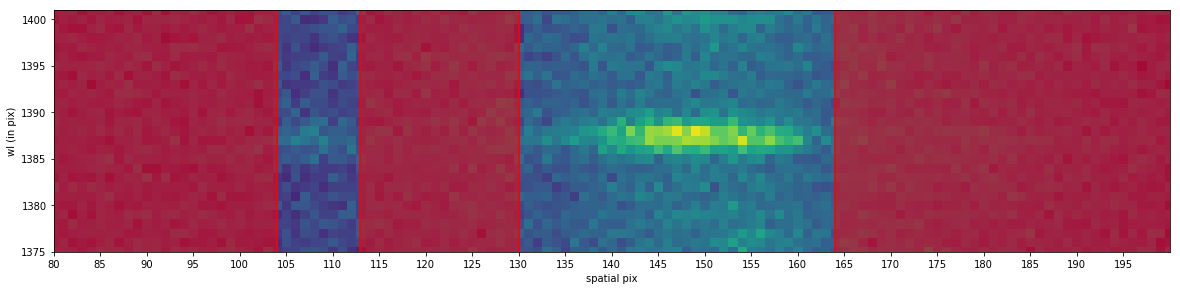

In [158]:
# trying different mask regions


#########################################plotting##################################################
y_unc_pixs = means_Wsigma_fullccd - gaussmeans_specpix_fullccd_MASKED #needed errors in pixs
subimg_fullccd =subimg2.data

vmin=-10
vmax=45
fig, ax = plt.subplots(1,figsize=(20,10))
ax.imshow(subimg_fullccd.T,vmin=vmin,vmax=vmax);
ax.set_ylabel('wl (in pix)')
ax.set_xlabel('spatial pix')
ax.axvline(113,color='r')
ax.axvline(104,color='r')
ax.axvline(130,color='r')
ax.axvline(164,color='r')
# ax.axvline(177.5,color='r')
# ax.axvline(179.5,color='r')

ax.axvspan(80, 104, alpha=0.5, color='red')
ax.axvspan(113, 130, alpha=0.5, color='red')
ax.axvspan(164, 200, alpha=0.5, color='red')
#ax.axvspan(179.5, 200, alpha=0.5, color='red')
ax.set_ylim(1375,1401)#1384,1390)
ax.set_xlim(80,200)
ax.set_xticks(np.arange(80, 200, 5.0));

####################################creating masks################################################


#collecting relevant info
#arrays converted to real world
#distances_sections_target,y_axis_Gvelocity, v_unc

#in full ccd pix want to mask these space[idx]
mask_reg1 = (0,104)
mask_reg2 =(113,130)
mas_reg3 = (164,190)
#mask_reg4 = (179.5,190)

#pix arr corresponding to full ccd for real world arrays
pix_arr_ps = np.arange(np.min(target_spacepix_fullccd),np.max(target_spacepix_fullccd)+1,1)
pix_arr_ps


#converting bad fit idx from target pix space to full ccd pix space
bad_idx_fullccd = all_bad_idxs + space_pix_correction
bad_idx_fullccd

##########################################apply mask in real units####################################################
#connecting pix arrs from pix space to real world


pix_arr_rw =[]
for count,arr in enumerate(pix_arr_ps):
   # print(arr)
    arr = int(arr)
    if  arr <= 104: #region 1
        count = np.nan
    elif arr >= 113 and arr <=130: #region 2
        count = np.nan
#     elif arr >= 164 and arr <= 175: #region 3 
#         count = np.nan
#     elif arr >= 177 and arr <=178: #extra region to include 1 more good but exclude 2 bad
#         count = np.nan
    elif arr >= 164: #region 4
        count = np.nan
    elif arr in bad_idx_fullccd: #original bad fits 
        count = np.nan
    else:
        count = count
    pix_arr_rw.append(count)
pix_arr_rw_msk = np.asarray(pix_arr_rw)
pix_arr_rw_msk,len(pix_arr_rw_msk)

# check fit with newly masked regions

Model: eriksmodel
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Parameters:
    r_cen alpha  beta       sigma       omega     v_offset    
    ----- ----- ----- ----------------- ----- ----------------
      4.7 1e-09 1e-09 34.83408509097209   0.0 9.30879102201778


/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


(-75, 100)

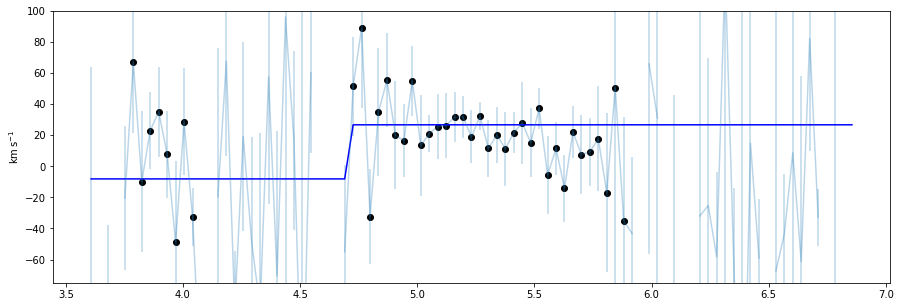

In [159]:
# added in a v-offset & dr b/c v-offset didnt do enough


#uses core from sections
#eriks model eqt 5
@models.custom_model #very necessary line
def eriksmodel(r,r_cen=0, alpha=.00001, beta=.00001, sigma=-20, omega=.05,v_offset=0):
    dr = r-r_cen
    return (dr * ((alpha + beta)/2) + (sigma - dr*(alpha - beta)) * (np.arctan(dr / omega))/np.pi)+v_offset

# setting bounds
m_init = eriksmodel(bounds={'r_cen': (4.7,5.5), 'alpha':(.01,.000000001), 'beta':(.01,.000000001),'sigma': (-300,300),'omega':(0,100)})
m_init.r_cen=5.35
m_init.sigma=10

#fit model to data
fit = fitting.LevMarLSQFitter()
nan_msk2 = ~np.isnan(pix_arr_rw_msk)
m = fit(m_init, distances_sections_target[nan_msk2], y_axis_Gvelocity.value[nan_msk2],weights=(1/(v_unc.value[nan_msk2])**2))
print(m)
#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections_target[nan_msk2],y_axis_Gvelocity[nan_msk2], color='k')
plt.errorbar(distances_sections_target, y_axis_Gvelocity, yerr=v_unc,alpha=.3)
########################################################################
plt.plot(distances_sections_target, m(distances_sections_target), color='b')
#plt.ylim(0,40) #zooms to see data good, if fit is good
#plt.ylim(-200,200)
plt.ylim(-75,100)

# amending masked regions again

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 91)

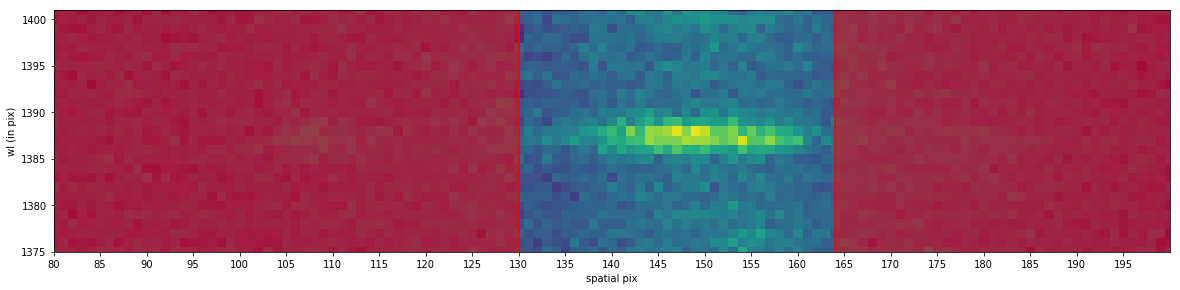

In [161]:
# trying different mask regions


#########################################plotting##################################################
y_unc_pixs = means_Wsigma_fullccd - gaussmeans_specpix_fullccd_MASKED #needed errors in pixs
subimg_fullccd =subimg2.data

vmin=-10
vmax=45
fig, ax = plt.subplots(1,figsize=(20,10))
ax.imshow(subimg_fullccd.T,vmin=vmin,vmax=vmax);
ax.set_ylabel('wl (in pix)')
ax.set_xlabel('spatial pix')
# ax.axvline(113,color='r')
# ax.axvline(104,color='r')
ax.axvline(130,color='r')
ax.axvline(164,color='r')
# ax.axvline(177.5,color='r')
# ax.axvline(179.5,color='r')

#ax.axvspan(80, 104, alpha=0.5, color='red')
ax.axvspan(80, 130, alpha=0.5, color='red')
ax.axvspan(164, 200, alpha=0.5, color='red')
#ax.axvspan(179.5, 200, alpha=0.5, color='red')
ax.set_ylim(1375,1401)#1384,1390)
ax.set_xlim(80,200)
ax.set_xticks(np.arange(80, 200, 5.0));

####################################creating masks################################################


#collecting relevant info
#arrays converted to real world
#distances_sections_target,y_axis_Gvelocity, v_unc

#in full ccd pix want to mask these space[idx]
#mask_reg1 = (0,104)
mask_reg2 =(0,130)
mas_reg3 = (164,190)
#mask_reg4 = (179.5,190)

#pix arr corresponding to full ccd for real world arrays
pix_arr_ps = np.arange(np.min(target_spacepix_fullccd),np.max(target_spacepix_fullccd)+1,1)
pix_arr_ps


#converting bad fit idx from target pix space to full ccd pix space
bad_idx_fullccd = all_bad_idxs + space_pix_correction
bad_idx_fullccd

##########################################apply mask in real units####################################################
#connecting pix arrs from pix space to real world


pix_arr_rw =[]
for count,arr in enumerate(pix_arr_ps):
   # print(arr)
    arr = int(arr)
    if  arr <= 130: #region 1
        count = np.nan
#     elif arr >= 113 and arr <=130: #region 2
#         count = np.nan
#     elif arr >= 164 and arr <= 175: #region 3 
#         count = np.nan
#     elif arr >= 177 and arr <=178: #extra region to include 1 more good but exclude 2 bad
#         count = np.nan
    elif arr >= 164: #region 4
        count = np.nan
    elif arr in bad_idx_fullccd: #original bad fits 
        count = np.nan
    else:
        count = count
    pix_arr_rw.append(count)
pix_arr_rw_msk = np.asarray(pix_arr_rw)
pix_arr_rw_msk,len(pix_arr_rw_msk)

# checking amended mask fit

Model: eriksmodel
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Parameters:
    r_cen alpha  beta        sigma               omega             v_offset     
    ----- ----- ----- ------------------- ------------------- ------------------
      5.7 1e-09 1e-09 -37.672207396479855 0.10165570826724445 11.921246112063725


/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


(-75, 100)

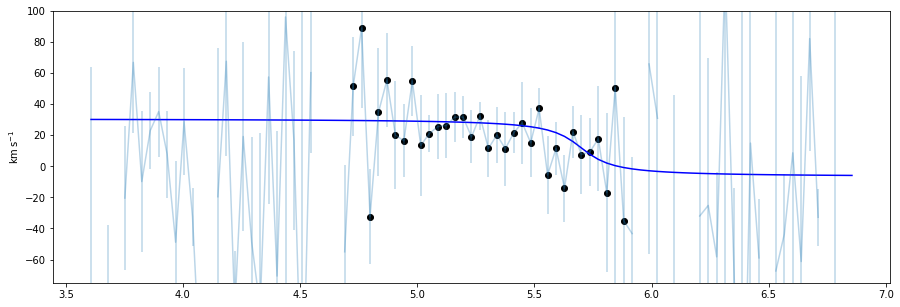

In [173]:
# added in a v-offset & dr b/c v-offset didnt do enough


#uses core from sections
#eriks model eqt 5
@models.custom_model #very necessary line
def eriksmodel(r,r_cen=0, alpha=.00001, beta=.00001, sigma=20, omega=.05,v_offset=0):
    dr = r-r_cen
    return (dr * ((alpha + beta)/2) + (sigma - dr*(alpha - beta)) * (np.arctan(dr / omega))/np.pi)+v_offset

# setting bounds
m_init = eriksmodel(bounds={'r_cen': (4.7,5.7), 'alpha':(.01,.000000001), 'beta':(.01,.000000001),'sigma': (-300,300),'omega':(0,100)})
m_init.r_cen=5.5
m_init.sigma=-5

#fit model to data
fit = fitting.LevMarLSQFitter()
nan_msk2 = ~np.isnan(pix_arr_rw_msk)
m = fit(m_init, distances_sections_target[nan_msk2], y_axis_Gvelocity.value[nan_msk2],weights=(1/(v_unc.value[nan_msk2])**2))
print(m)
#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections_target[nan_msk2],y_axis_Gvelocity[nan_msk2], color='k')
plt.errorbar(distances_sections_target, y_axis_Gvelocity, yerr=v_unc,alpha=.3)
########################################################################
plt.plot(distances_sections_target, m(distances_sections_target), color='b')
#plt.ylim(0,40) #zooms to see data good, if fit is good
#plt.ylim(-200,200)
plt.ylim(-75,100)

In [ ]:
# above values similar to cell 148
Parameters:
          r_cen       alpha  beta       sigma        omega      v_offset     
    ----------------- ----- ----- ------------------ ----- ------------------
    5.575767935846657 1e-09 1e-09 -28.86160385303176   0.1 12.207524253104017

In [154]:
#wont be general b/c areas to bin will differ


# binned_idx=[]
# for count,val in enumerate(myt['pix']):
#     #print(val)
#     if np.isnan(val) == True: #nans
#         val = val
#         binned_idx.append(val)
#     elif count in range(5,11,2): #binning first good signal region
#         start = int(myt['pix'][count])
#         end = int(myt['pix'][count + 2])
#         #begin =
#         print('ranges',start,end)
#         val = np.mean((start,end))
#         print('val:',val)
#         binned_idx.append(val)
#     elif count in range(5,12,1): #not binning in bad data at edges
#         print('skipping',count)
#     else: #leaving other good signal regions alone
#         val = val
#         binned_idx.append(val)
# print(len(binned_idx),binned_idx,'need to amend this to do binning of other arrays too now')

In [155]:
#np.sum([[3, 1], [np.nan, 5]], where=[True, True], axis=0)

# -----------OLD BELOW THIS--------------

In [156]:
throw an error here so you dont run below

SyntaxError: invalid syntax (<ipython-input-156-6a8d3031fcb6>, line 1)

In [ ]:
#matrix fix if needed above

#takes out unc value from each matrix
#exploring means_unc problem/solution


# print('10',type(means_unc[10]))

# #determining which index of matrix value i want
# #print(np.shape(means_unc), 'MATRIX', means_unc[1],'SECOND ROW', means_unc[1][1], 'MIDDLE',means_unc[1][1][1])
# print('possible problem matrix here',means_unc[10])

# #setting up indexing array to explore all the matrices in for loop
# matrix = np.arange(0,len(means_unc),1)
# print('matrix length array', matrix)


# badmatrix = np.array([ 0.0, 0.0, 0.0, 0.0, 100.0, 0.0, 0.0, 0.0, 0.0])
# badmatrix = np.reshape(badmatrix,(3,3))
# print('shape',np.shape(badmatrix),'middle index',badmatrix[1][1])

# unc = []
# uncs = [] 
# badvalues = []  
    
# for i in matrix:
#     #np.array([means_unc])
#     #empty == type(np.any(means_unc[10])) #np.bool
#     #print('empty',empty)
#     if np.any(means_unc[i]) == None:
#         print('bad matrix at array:',i)
#         badvalues.append(i)
#         for j in badvalues:
#             means_unc[j] = badmatrix
#             ##uncs.append(means_unc[j][1][1])
#             #print('one replaced uncs',uncs)
#             #print('replaced with', means_unc[j])
#             #print('right index?', means_unc[j][1][1])
#             #print('replaced type',type(means_unc[j]))
#     else:
#         np.all(means_unc[i]) == np.all(means_unc[i])
#         #print('reg type',type(means_unc[i]),'i=',i) #np.ndarray
#     uncs.append(means_unc[i][1][1]) #does same as below
#     #print('one original uncs',uncs)
    
# unc.append(uncs) #does same as above
# print('unc',np.shape(unc),len(unc),'uncs',np.shape(uncs),len(uncs))
# print('uncs best b/c of shape but unc or uncs are both same array of middle term from matrices....ie sigma**2')
# #print('unc len',len(unc),'unc shape',np.shape(unc),'unc',unc)

# #print("another row", 'MATRIX', means_unc[51],'SECOND ROW', means_unc[51][1], 'MIDDLE',means_unc[51][1][1])
# #print('maybe uncs is best',uncs,'shape',np.shape(uncs),'length',len(uncs))

# print('use uncs for means_unc')


In [ ]:
# #converted centroids to wl to see how much of a shift there is

# #applies ds
# ################################################################
# wl_centroids = np.array(ds_red.pixtowl(centroid_specpix_fullccd))
# #################################################################

# #plotting
# plt.figure(figsize=(20,10))
# plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
# plt.ylabel('spectral direction - WL value of best emission line center',fontsize=20)
# plt.plot(target_spacepix_fullccd[3::],wl_centroids[3::])#(spaital pix index,corrected "wl" of centroid values (still in pix space))
# ##########################################################
# plt.title('h-alpha centroids in wl values',fontsize=35)
# ##########################################################

In [ ]:
# #USING SECTIONS SURROUNDING HALPHA WL RANGE
# np.shape(flux_data)#(226,4104) #note that this is missing those wl's


# #making arrays surrounding best emission line
# ################################################
# upperha = 1387
# lowerha = 1376
# #################################################
# width_sections = 10 #reduced from 50 to 25 to avoid cosmic rays skewing to higher pix side
# upper_one = lowerha - 1 #distance to avoid line emission contaminating core determination
# lower_one = upper_one - width_sections
# lower_two = upperha + 1 #giving it some distance
# upper_two = lower_two + width_sections
# first_section = flux_data[:,lower_one:upper_one]
# second_section = flux_data[:,lower_two:upper_two]
# print('shape of first section:', np.shape(first_section), 'matches shape of second section:', np.shape(second_section))


# #collapsing both sections in the spatial direction (histogram like)
# first_section_sum = np.sum(first_section,axis=1) 
# first_section2d = first_section_sum[:,np.newaxis] #2d required to centroid
# second_section_sum = np.sum(second_section,axis=1)
# second_section2d = second_section_sum[:,np.newaxis] #2d required to centroid
# print('shape of first section 2d:', np.shape(first_section2d))
# print('shape of second section 2d:', np.shape(second_section2d))


# #does the centroiding
# x_first, y_first = centroid_com(first_section2d)
# x_second, y_second = centroid_com(second_section2d)
# print('first section centroid x,y:',x_first,y_first)
# print('second section centroid x,y:',x_second,y_second)



# #verify by plots
# f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
# ax1.plot(first_section2d);
# ax2.plot(second_section2d);
# #note below had to reverse xy centroids to visualize correctly, not sure why it inverted tho...
# ax1.plot(y_first,x_first, '.', markersize=10)
# ax2.plot(y_second,x_second, '.', markersize=10)

# #averaging the two core values, the y's
# core_array = np.array([y_first,y_second])
# core_avgcentroids = np.mean(core_array)
# print('This is the average pixel value of the core BEFORE SPATIAL CORRECTIONS',core_avgcentroids)

# #FULL CCD pixel value of core
# core_from_sections = core_avgcentroids + space_pix_correction #corrects for spatial axis target cutout
# print('Pixel Value of core along spatial axis wrt full CCD size',core_from_sections)

In [ ]:
# #NOTE THAT THIS CELL USES GAUSSIAN VALUES.....IF CENTROIDS HAVE BETTER FIT (less likely) CHANGE IT

# #robust way to clean data (to avoid bad g fits)
# #################################################################
# cleaned_gaussmeans = sigma_clip(gaussian_means, sigma=3)
# ################################################################
# avg_of_gmeans = np.mean(cleaned_gaussmeans)

# #correcting avg Ha wl pixel value to reflect its place on the full ccd scale
# bestline_corewl_pix_fullccd = avg_of_gmeans + wl_pix_correction + bestline_range_correction[0]
# print(bestline_corewl_pix_fullccd)

# #applying ds to get pix to wl value
# ########################################################################
# bestline_core_wl = ds_red.pixtowl(bestline_corewl_pix_fullccd)*u.angstrom
# #########################################################################

# print('Best emission line "core" wl (based on gaussian fits) is:',bestline_core_wl)

In [ ]:
# #centering around core first

# #still in pixel space
# distance_pix_wrtcore_sections = target_spacepix_fullccd - core_from_sections #for core wl using 2 sections around best emission line

In [ ]:
# #actual converting for loop CENTROIDS pixels to kpc
# #good for core defined by 2 sections around halpha

# #converts pixels to kpc (distance profile)
# arcmins_sections =[]
# distances_sections=[]
# more_sections = []


# #converts pix to kpc and saves as quantity list
# for i in distance_pix_wrtcore_sections:
#     r_in_arcmin = 1*u.arcmin
#     redplatescale = 0.293*u.arcsec/u.pixel
#     blueplatescale = 0.389*u.arcsec/u.pixel
#     dbsp_pix_equiv_red = u.pixel_scale(redplatescale)
#     dbsp_pix_equiv_blue = u.pixel_scale(blueplatescale)
#     r_in_pixel = i*u.pixel
#     ################################################################
#     r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv_red)
#     distance = 25.4*u.Mpc # distance of object (host) from us
#     ###############################################################
#     rad_to_arcmin = (1*u.rad).to('arcmin')
#     r_in_kpc = ((r_in_arcmin/rad_to_arcmin)*distance).to("kpc") #gets radians*distancefromus for gal width in kpc
#     more_sections = r_in_kpc #/ (1*u.kpc)
#     distances_sections.append(more_sections.value)
# distances_sections = np.array(distances_sections)

In [ ]:
# #CENTROID plot with pix-wls & kpc

# plt.figure(figsize=(25,10))
# plt.title('Best emission line Centroids', SIZE=25)
# plt.xlabel('RADIUS in Kpc',fontsize=20)
# plt.ylabel('spectral direction in pixels',fontsize=20)
# plt.plot(distances_sections[3::] * u.kpc, centroid_specpix_fullccd[3::])

In [ ]:
# #GAUSSIAN MEANS plot with pix-wls & kpc

# plt.figure(figsize=(25,10))
# plt.title('Best emission line Gaussian means', SIZE=25)
# plt.xlabel('RADIUS in Kpc',fontsize=20)
# plt.ylabel('spectral direction in pixels',fontsize=20)
# plt.plot(distances_sections * u.kpc, gaussmeans_specpix_fullccd) #didnt need [3::], not sure why

In [ ]:
# #convert pix to wl via ds
# ###################################################################
# centroids_wl = ds_red.pixtowl(centroid_specpix_fullccd)*u.angstrom
# gauss_meanWstd_wl  = ds_red.pixtowl(gaussmax_specpix_fullccd)*u.angstrom
# gauss_means_wl = ds_red.pixtowl(gaussmeans_specpix_fullccd)*u.angstrom
# core_wl_sections = ds_red.pixtowl(core_from_sections)*u.angstrom
# ####################################################################

In [ ]:
# #using redshift formula to get velocity

# #((obs_wl - true_wl)/true_wl)* c = velocity
# #except what we want is  v_not relative to core - v_of core

# #velocities NOT yet relative to the core
# ##############################################################################
# v_spec_gaussians = ((gauss_means_wl/(6563*u.angstrom)) -1) * const.c #gaussian velocities
# v_spec_centroids = (centroids_wl /(6563*u.angstrom) -1) * const.c #centroid velocities
# v_core = ((bestline_core_wl/(6563*u.angstrom)) -1) * const.c #core velocity
# ###############################################################################

# #velocities relative to the core from sections
# y_axis_Gvelocity = (v_spec_gaussians - v_core).to('km/s')  #gaussian
# y_axis_Cvelocity = (v_spec_centroids - v_core).to('km/s') #centroids

# print("velocity of best emission line's spectral 'core':",v_core)

In [ ]:
# plt.figure(figsize=(25,10))
# #######################################################
# plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
# #######################################################
# plt.xlabel('RADIUS in Kpc',fontsize=20)
# plt.ylabel('VELOCITY in km/s',fontsize=20)
# plt.plot(distances_sections * u.kpc, y_axis_Gvelocity)
# #plt.ylim(-250,250) #adjust as needed to center around zero
# plt.plot(0,0,'.', markersize=25)

In [ ]:
# plt.figure(figsize=(25,10))
# #######################################################
# plt.title('Rotation Curve via Halpha Centroids', SIZE=25)
# #######################################################
# plt.xlabel('RADIUS in Kpc',fontsize=20)
# plt.ylabel('VELOCITY in km/s',fontsize=20)
# plt.plot(distances_sections[2::] * u.kpc, y_axis_Cvelocity[2::])
# #plt.ylim(-250,250) #adjust as needed to center around zero
# plt.plot(0,0,'.', markersize=25)

In [ ]:
# #using output from GAUSSIAN fit to determine error; tbd how to for CENTROIDS

# #method to obtain sigma = subttract velocities of (mean+sigma) - mean = sigma 
# sigma_gauss_pix = np.sqrt(np.abs(uncs)) #taking sqrt of unc to get a true sigma
# #correct to full ccd pix scale
# means_Wsigma_fullccd = gaussian_means + sigma_gauss_pix + wl_pix_correction + bestline_range_correction[0]
# #apply ds
# means_max_wl = ds_red.pixtowl(means_Wsigma_fullccd)*u.angstrom


# #making into velocities
# v_means_withsigma = (means_max_wl/ (6563*u.angstrom)-1) * const.c #be sure to check all values ok (no inf)
# #in converting pix2wl2vel section...already did same steps for means w/o sigma


# #extracting sigma velocity
# v_unc = (v_means_withsigma - v_spec_gaussians).to('km/s') 
# #print(np.shape(v_unc))
# #np.reshape(v_unc,(226,))
# print('v_unc', np.shape(v_unc))#make sure its same length as y_axis_Gvelocity

In [ ]:
# #rotation curve with gaussians with errorbars
# plt.figure(figsize=(25,10))


# arr = np.asarray #need to avoid setting array element as sequence
# #had to chop last value b/c in sigma array = -inf
# ###############################################################################
# plt.errorbar(arr(distances_sections[2::] * u.kpc), arr(y_axis_Gvelocity[2::]), yerr=arr(1/(v_unc[2::])))
# ###############################################################################
# plt.title('Rotation Curve via Halpha Gaussians with ErrorBars', SIZE=25)
# plt.xlabel('RADIUS in Kpc',fontsize=20)
# plt.ylabel('VELOCITY in km/s',fontsize=20)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.plot(0,0,'.',markersize=20)
# #plt.ylim(-250,250)
# plt.axhline(0)
# plt.ylim(2000,-2000)
# ##########################################################

In [ ]:
# #eriks model eqt 5

# @custom_model #very necessary line
# def eriksmodel(r, alpha=.1, beta=.1, sigma=250, omega=.4):
#     return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)


# #fit model to data
# m_init = eriksmodel()
# fit = LevMarLSQFitter()
# #print('here',m_init)
# m = fit(m_init, arr(distances_sections[:-1] * u.kpc), arr(y_axis_Gvelocity[:-1]),weights=arr(1/(v_unc[:-1])**2))
# print(m)
# #plot data & fit
# plt.figure(figsize=(15,5))
# ########################################################################
# plt.plot(distances_sections[2::], y_axis_Gvelocity[2::], color='k')
# ########################################################################
# plt.plot(distances_sections[:-1], m(distances_sections[:-1]), color='b')
# #plt.ylim(-230,200) #zooms to see data good, if fit is good
# #plt.ylim(-1000,2000) #to see whole effect of param playing on fit line